<center style ="font-size: xx-large; font-weight: 600; line-height: 1.1;">
A comparative investigation of validation accuracy in XGBoost and a Keras CNN.  
</center>  
<center>
Group 2220:  
Daniel Jordan,
Thevan Pasupathipillai,
Marco Lorenzetti and
Jake Jackson
</center>

## Introduction 

This Jupyter Notebook details the application of a Keras Convolutional Neural Network and XGBoost decision tree gradient boosting in a time series classification problem. The module tsFresh is used to identify the optimal training features of the time series data. The accuracy for each method is subsequently compared over various data sizes for 5 random permutations. This is further expanded upon and compared with a Feed Foward Neural Network FFNN, and a parameter investigation to find the simplest XGBoost model with good accuracy results.
<a id ="contents"></a>
## Contents

   [1a: Keras CNN vs XGBoost Accuracy](#cnn)  
   [1b: Optimal tsFresh Features for XGBoost](#features)  
   [1c: Feed Forward Neural Network (FNNN) vs XGBoost Accuracy](#fnn)  
   [2:  Parameter Analysis](#2D)


<a id="cnn"></a>
# 1a: Keras CNN vs XGBoost Accuracy
<a href ="#contents">
<p style="text-align: right;">return to contents</p>
</a>

## Setup

In [11]:
# !pip install tsfresh
# !wget https://raw.githubusercontent.com/DanHarJor/CompLabB-UNIPD-TeamDream/main/Daniel/04_XGBoost/DATA/x_ts_L60_Z12_A500_DX50_bias5_N10000.dat
# !wget https://raw.githubusercontent.com/DanHarJor/CompLabB-UNIPD-TeamDream/main/Daniel/04_XGBoost/DATA/y_ts_L60_Z12_A500_DX50_bias5_N10000.dat

#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1y3qcM4OSrzfQhj-iHyJF86TUQJNUXOE9' -O x_features_pick

In [12]:
import os
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.markers as mark
from tsfresh import extract_features
from xgboost import XGBClassifier, plot_tree

#create a random number generator 'rng' for data shuffles
rng = np.random.default_rng()

plt.rcParams['font.size'] = 14

#Load, scale and split Data ################################################################
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='x_'+str0
fnamey='y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

#rescale
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#rescale crude
x = x/400

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)

x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)
##########################################################################

def Show_data(x,L,nSamples = 2,title="data"):
    plt.figure(figsize = (nSamples*3,10))
    for i in range(nSamples):
        plt.plot(np.arange((i+1)*L,(i+1)*L+L),x[i])
        #plt.plot(np.arange(L,2*L),x[1])
        #plt.plot(np.arange(2*L,3*L),x[2])
    plt.title(title)
    plt.xlabel("time")
    plt.show()

def Show_history(fit, EPOCHS):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

##method 1
import tensorflow.random as tf_r
def compile_CNN(regLevel = 0.2):
    np.random.seed(12345)    
    tf_r.set_seed(12345)
    ## from keras import regularizers, initializers
    reg = tf.keras.regularizers.l1(regLevel) ## raised to 0.2
    #reg = regularizers.l1(0.1)
    ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05,seed=None)
    model = Sequential()
    # -----2-- Convelutional layers
    model.add(Conv1D(filters=5, kernel_size=11, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7, 
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_class, activation='softmax')) # softmax !
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

#used to remember best weights
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = os.getcwd(),
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose = 0)
CNN = compile_CNN()


data:  10000


## CNN at various data sizes

In [13]:
Ndat = [20,50,100,150,200,250,300,400,500,600,700,800,900,1000,2000,3000,7000,8000]
batch_sizes = [10,20,30,50,50,50,100,100,100,250,250,250,250,250,250,250,250]
CNN_mean_acc = []
CNN_std_acc = []
CNN_acc = []

EPOCHS = 100 #needs tuned for comparison with XGBoost
for i in range(len(Ndat)):
    CNN_acc_temp = []
    N = Ndat[i]
    if i < 9:
        BATCH_SIZE =  batch_sizes[i] #not sure
    else: BATCH_SIZE = 250
    
    for j in range(10):
      #shuffle data
      permutation = rng.permutation(x_train.shape[0])
      # resize data
      s_x_train = (x_train[permutation])[0:N,:]
      s_y_train = (y_train[permutation])[0:N]
      #s_x_val = x_val[0:int(0.2*N),:]
      #s_y_val = y_val[0:int(0.2*N)]
    
      #train and test CNN
      CNN = compile_CNN()
      fit = CNN.fit(s_x_train,s_y_train,batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(x_val, y_val),
                      verbose=0, shuffle=True, callbacks=[model_checkpoint_callback])
      maxAcc = np.max(fit.history['val_accuracy'])
      CNN_acc_temp.append(maxAcc)
    print(CNN_acc_temp)
    CNN_acc.append(CNN_acc_temp)
    CNN_mean_acc.append(np.mean(CNN_acc_temp))
    CNN_std_acc.append(np.std(CNN_acc_temp))


INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written 

No handles with labels found to put in legend.


18
18
[0.023716239711725005, 0.024514531773833646, 0.050575291089744706, 0.039453164893525496, 0.06331239549521014, 0.05653458285138375, 0.06423939425642447, 0.10877271366322738, 0.13383430624504156, 0.10427804466177573, 0.11995745195025076, 0.11355823708408758, 0.14189679876391822, 0.03497645802584678, 0.011792050776463843, 0.15393009173200622, 0.1977630184391818, 0.21640774591500445]


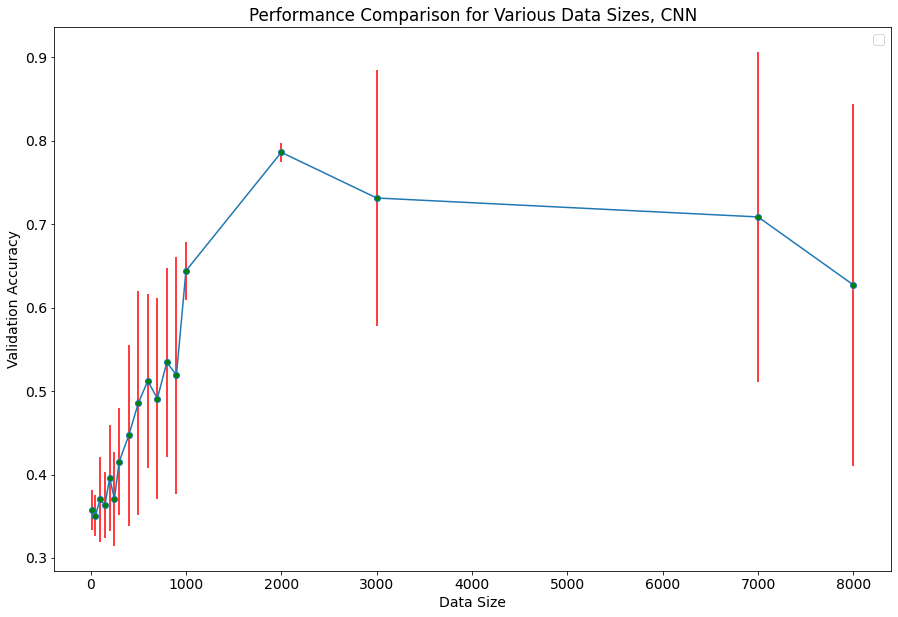

In [15]:
Ndat = [20,50,100,150,200,250,300,400,500,600,700,800,900,1000,2000,3000,7000,8000]
print(len(Ndat))
print(len(CNN_mean_acc))
figDataSize = plt.figure(figsize = (15,10))
#plt.plot(Ndat,CNN_mean_acc, 'r.-', label = 'CNN')
plt.errorbar(Ndat,CNN_mean_acc, yerr = CNN_std_acc,ecolor = 'r', marker = 'o',mfc = 'g')
plt.xlabel('Data Size')
plt.ylabel('Validation Accuracy')
#plt.xticks(Ndat,Ndat)
plt.title('Performance Comparison for Various Data Sizes, CNN')
plt.legend()

print(CNN_std_acc)

## XGBoost with tsfresh

In [4]:
#turn data into a dataframe that is compatable with tsfresh
def get_df(x):
    '''Build input dataframe for given data series
    Input:
    var = array of time series, (#samples,time,1)
    Return:
    df = dataframe ready for features extraction
    '''
    
    #N = #samples, t = timesteps
    N, t = x.shape[0], x.shape[1]
    #build id columns
    id_col = np.repeat(np.arange(N),t)
    #build time columns
    time_col = np.tile(np.arange(t),N)
    #build var columns
    x_col = x.flatten()
      
    #build dict for df
    x_dict = {'id':id_col,'time':time_col,'value':x_col}
        
    #return dataframe
    return pd.DataFrame(x_dict)

df = get_df(x)

#extract features
# x_features = extract_features(
#                             df, #our dataframe
#                             column_id='id', #sample id, from 0 to N
#                             column_sort='time', #timestep, from 0 to t
#                             column_kind=None, #we have only one feature
#                             column_value='value', #value of input 
#                             n_jobs=1) #number of cores



In [1]:

import pickle
##save to pickle file
#with open('x_features_pick', 'wb') as file:
#    pickle.dump(x_features, file)


#load from pickle file
with open('x_features_pick', 'rb') as file:
     x_features = pickle.load(file)


In [5]:
#remove columns with NaN or inf
x_features.replace([np.inf, -np.inf], np.nan)
x_features = x_features.dropna(axis='columns')

#split data into training and validation
perc_train=0.8
N_train = int(perc_train*N)
x_train = x_features[0:N_train]
y_train_xgb = categ[0:N_train]
x_val = x_features[N_train:]
y_val_xgb = categ[N_train:]
N_val = len(x_val)
print('N = ',N,'   N_train=',N_train,'  N_val=',N_val,'  n_class=',n_class)

#rescale: in each feature, remove average and divide by std
average = np.mean(x_train,axis=0)
x_train -= average
x_val -= average

std = np.std(x_train,axis=0)
x_train /= std
x_val /= std

def XGB_compile():
    # reproducibility
    np.random.seed(12345)

    #define parameters for xgboost
    params = {'max_depth':6,'min_child_weight':1,\
              'learning_rate':0.3,'use_label_encoder':False}

    #build model with given params
    model = XGBClassifier(**params)
    return model


N =  10000    N_train= 8000   N_val= 2000   n_class= 3


In [7]:
Ndat = [20,50,100,150,200,250,300,400,500,600,700,800,900,1000,2000,3000,7000,8000]
fracs = np.array(Ndat)/8000
XGB_mean_acc = []
XGB_std_acc = []
XGB_acc = []

for i in range(len(Ndat)):
    XGB_acc_temp = []
    
    for j in range(5):
      #shuffle data and resize
      shuffle = x_train.sample(frac = fracs[i])
      index = shuffle.index.tolist()
      # resize data
      s_x_train = shuffle#.reset_index()
      s_y_train = (y_train_xgb[index])[0:len(index)]
      #s_x_val = x_val[0:int(0.2*N),:]
      #s_y_val = y_val[0:int(0.2*N)]
      XGB = XGB_compile()
      fit = XGB.fit(s_x_train.values,s_y_train)
      y_pred = XGB.predict(x_val.values)
      acc = np.sum([y_pred == y_val_xgb])/len(y_val_xgb)
      XGB_acc_temp.append(acc)
    XGB_acc.append(XGB_acc_temp)
    XGB_mean_acc.append(np.mean(XGB_acc_temp))
    XGB_std_acc.append(np.std(XGB_acc_temp))


No handles with labels found to put in legend.


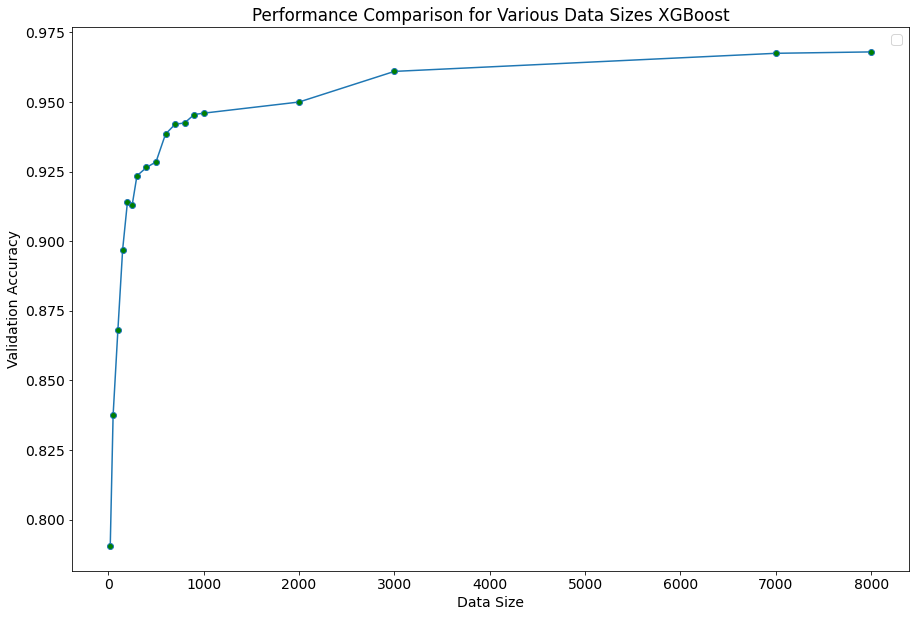

In [16]:
figDataSize = plt.figure(figsize = (15,10))
plt.errorbar(Ndat,XGB_mean_acc, yerr = XGB_std_acc,ecolor = 'r', marker = 'o',mfc = 'g')
plt.title('Performance Comparison for Various Data Sizes XGBoost')
plt.xlabel('Data Size')
plt.ylabel('Validation Accuracy')
plt.legend()

In [9]:
print(XGB_std_acc)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1102230246251565e-16, 0.0, 0.0, 0.0, 1.1102230246251565e-16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## Comparing XGBoost with CNN

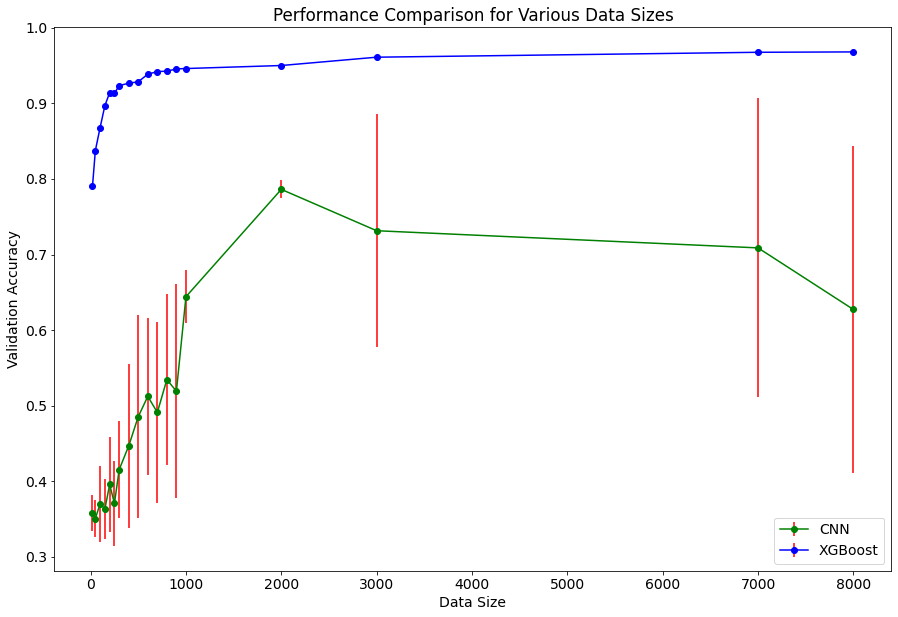

In [18]:
figDataSize = plt.figure(figsize = (15,10))
plt.errorbar(Ndat,CNN_mean_acc, yerr = CNN_std_acc,ecolor = 'r', marker = 'o',mfc = 'g', color = 'g', label = 'CNN')
plt.errorbar(Ndat,XGB_mean_acc, yerr = XGB_std_acc,ecolor = 'r', marker = 'o',mfc = 'b', color = 'b',label = 'XGBoost')
plt.xlabel('Data Size')
plt.ylabel('Validation Accuracy')
plt.title('Performance Comparison for Various Data Sizes')
plt.legend()

## Conclusion

XGBoost massivly outperformes the CNN. It is more stable which can be seen by the lack of variance with different runs. It achieves a higher accuracy at all of the data sizes. 

I suspect this is because of the simplicity of the problem. Perhaps the CNN could outperform XGBoost in solving more complex problems with even larger datasets. 

<a id="features"> </a>
# 1b: Optimal tsFresh Features for XGBoost
<a href ="#contents">
<p style="text-align: right;">return to contents</p>
</a>
The aim of this section is to understand the features that have been identified as important for XGBoost classification of the time series problem.

## Set up

In [2]:
!pip install tsfresh

     |████████████████████████████████| 822 kB 47.8 MB/s 
     |████████████████████████████████| 802 kB 21.6 MB/s 
     |████████████████████████████████| 802 kB 45.1 MB/s 
     |████████████████████████████████| 793 kB 48.9 MB/s 
     |████████████████████████████████| 793 kB 39.9 MB/s 
     |████████████████████████████████| 791 kB 58.9 MB/s 
     |████████████████████████████████| 786 kB 56.0 MB/s 
     |████████████████████████████████| 779 kB 53.5 MB/s 
     |████████████████████████████████| 778 kB 51.8 MB/s 
     |████████████████████████████████| 776 kB 46.4 MB/s 
     |████████████████████████████████| 769 kB 36.7 MB/s 
     |████████████████████████████████| 766 kB 48.6 MB/s 
     |████████████████████████████████| 1.0 MB 41.9 MB/s 
     |████████████████████████████████| 722 kB 58.9 MB/s 
     |████████████████████████████████| 722 kB 51.2 MB/s 
     |████████████████████████████████| 715 kB 45.0 MB/s 
     |████████████████████████████████| 705 kB 59.8 MB/s 
     |████████

In [3]:
#link to xfeatures pickle
#https://drive.google.com/file/d/1y3qcM4OSrzfQhj-iHyJF86TUQJNUXOE9/view?usp=sharing
#download x_features_pick
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1y3qcM4OSrzfQhj-iHyJF86TUQJNUXOE9' -O x_features_pick

#get data
!wget https://raw.githubusercontent.com/DanHarJor/CompLabB-UNIPD-TeamDream/main/Daniel/04_XGBoost/DATA/x_ts_L60_Z12_A500_DX50_bias5_N10000.dat
!wget https://raw.githubusercontent.com/DanHarJor/CompLabB-UNIPD-TeamDream/main/Daniel/04_XGBoost/DATA/y_ts_L60_Z12_A500_DX50_bias5_N10000.dat


--2022-04-02 14:08:06--  https://docs.google.com/uc?export=download&id=1y3qcM4OSrzfQhj-iHyJF86TUQJNUXOE9
Resolving docs.google.com (docs.google.com)... 173.194.195.139, 173.194.195.101, 173.194.195.100, ...
Connecting to docs.google.com (docs.google.com)|173.194.195.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-6o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gne2posjc5glscvost3sdne3svdrcl90/1648908450000/02190001126285980519/*/1y3qcM4OSrzfQhj-iHyJF86TUQJNUXOE9?e=download [following]
--2022-04-02 14:08:08--  https://doc-0g-6o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gne2posjc5glscvost3sdne3svdrcl90/1648908450000/02190001126285980519/*/1y3qcM4OSrzfQhj-iHyJF86TUQJNUXOE9?e=download
Resolving doc-0g-6o-docs.googleusercontent.com (doc-0g-6o-docs.googleusercontent.com)... 142.250.152.132, 2607:f8b0:4001:c56::84
Connecting to doc-0g-6o-docs.googleusercontent.com (doc-0g-6o-docs

## Import features as a pickle
The feature extraction took some time. So I saved it as a pickel file that I can load in much faster.

In [1]:
import pickle
#load pickle file
with open('x_features_pick', 'rb') as file:
    x_features = pickle.load(file)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from tsfresh import extract_features
from xgboost import XGBClassifier, plot_tree
import seaborn as sns

In [3]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='x_'+str0
fnamey='y_'+str0
n_class = 3 

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

# note: here it does not need to be converted to the 3-bit version, a label remains y[i]=0,1,2
y = np.loadtxt(fnamey, dtype=int)

#remove columns with NaN or inf
x_features.replace([np.inf, -np.inf], np.nan)
x_features = x_features.dropna(axis='columns')

#split data into training and validation

perc_train=0.8
N_train = int(perc_train*N)
x_train = x_features[:N_train]
y_train = y[:N_train]
x_val = x_features[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  n_class=',n_class)

#rescale: in each feature, remove average and divide by std
if True:
    average = np.mean(x_train,axis=0)
    x_train -= average
    x_val -= average

    std = np.std(x_train,axis=0)
    x_train /= std
    x_val /= std

# reproducibility
np.random.seed(12345)

#define parameters for xgboost
params = {'max_depth':6,'min_child_weight':1,\
          'learning_rate':0.3,'use_label_encoder':False}

#build model with given params
model = XGBClassifier(**params)

#fit
model.fit(x_train.values,y_train)

N_train= 8000   N_val= 2000   n_class= 3


XGBClassifier(learning_rate=0.3, max_depth=6, objective='multi:softprob',
              use_label_encoder=False)

## Get important features

In [4]:
#get feature names
feature_names = x_features.columns.values

#empty dict
feat_imp = {}
#get f importance from model
for i,f in enumerate(feature_names):
    feat_imp[f] = model.feature_importances_[i]
#sort features depending on their importances
feat_imp = dict(sorted(feat_imp.items(), reverse=True, key=lambda item: item[1]))

In [5]:
minval=0.005
print('------------- Feature importance sum = '+str(np.sum(model.feature_importances_)))
print('------------- Showing feature with importance > '+str(minval))
for i,k in enumerate(feat_imp.keys()):
    if feat_imp[k]>minval: print(i+1,k,feat_imp[k])

------------- Feature importance sum = 1.0000001
------------- Showing feature with importance > 0.005
1 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0 0.122241266
2 value__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0 0.12137273
3 value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0 0.11570879
4 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4 0.09589055
5 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6 0.055770185
6 value__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.026710652
7 value__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0 0.015129274
8 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2 0.012425136
9 value__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20) 0.011654274
10 value__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.011278342
11 value__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.011247869
12 value__change_quantil

value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0
value__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0
value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0
value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4
value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6


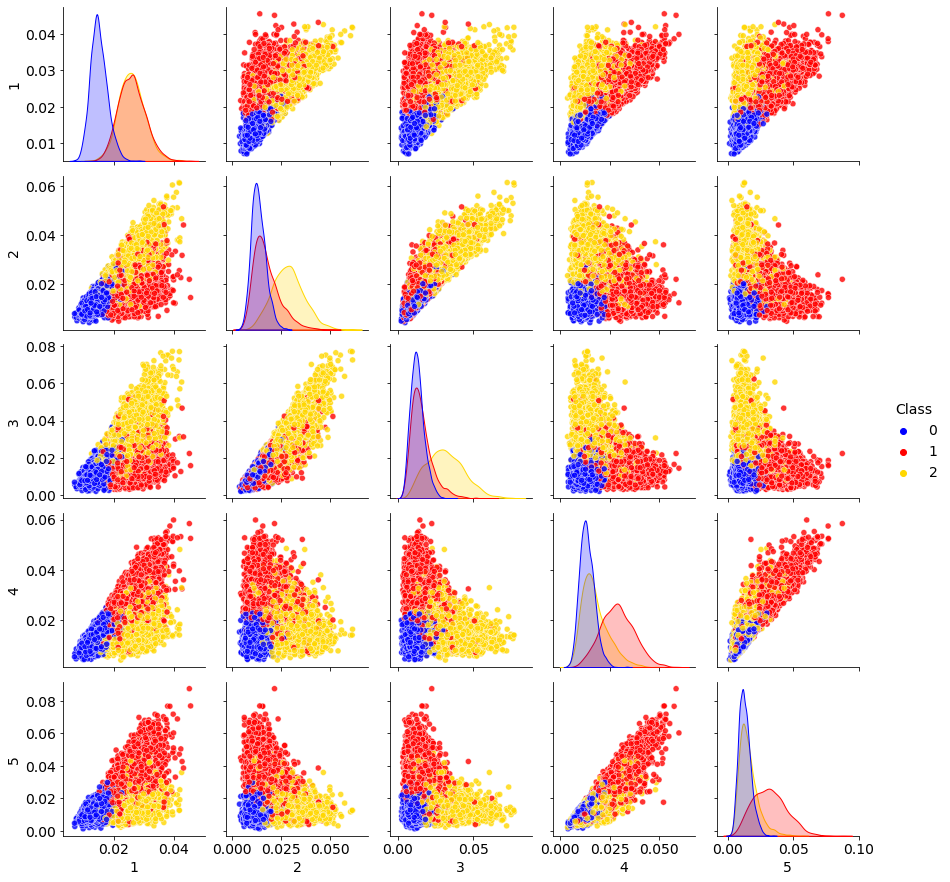

In [6]:
#get feature names given importance order
features = list(feat_imp.keys())

#build dataframe for sns pairplot
df = pd.DataFrame({'1':x_features[features[0]],\
                   '2':x_features[features[1]],\
                   '3':x_features[features[2]],\
                   '4':x_features[features[3]],\
                   '5':x_features[features[4]],\
                   'Class':y})
#pairplot with seaborn
pal = sns.blend_palette(["blue","red","gold"],n_class)
sns.pairplot(df,hue='Class',plot_kws=dict(alpha=0.8),palette=pal);

for i in range(5):
  print(features[i])

<a id ="features"></a>
# What are these features? 

The 5 most important features are all very similar. The only difference is the ql and qh values which stand for lower quantile and higher quantile.

How are these features extracted from the time series samples?

From looking at the doccumentation I have made my conclusions. Consider 1 sample, which is a time series. The first order differences are calculated. To know what this is please see the example below.  
time  ----------------------1----2----3----4-----5  
values -------------------1----3----4----7----10   
first order   -----------------2----1----3----3  
second order ---------------1----2----0   

Some of these first order differences are used and the rest are discarded. They are kept if both the values used to calculate the difference are in the corridore. The corridore is a subset of the sample between the quantiles. To find the corridore first the sample is ordered. The position of each value in the order is called the rank. The lower and higher quantiles ql and qh are fractions. They are fractions of the rank that decide the bounds of the corridore. This is more easily understood by looking at the example below. Where the red dots show the quantile fraction of the rank and the green line is the data that represents the corridore. If the sample values used to calculate the difference reside in this corridore then the difference is used for the rest of the calculation. The variance of the surviving differences is calculated. This variance is the sample's feature value. This is what is fed into xgboost to represent the sample.

All of the 5 most important features are calculated in this way but with different quantiles.

### Plot Below
The plot below uses a real sample with dummy quartiles. It is mostly to illustrate the concept of the feature.

The blue line is the origional sample. The orange line is the sample ordered. The green section is the corridore. The solid green markers on the blue line represent the points of the origional sample that are within the corridore. Any first order difference calculated with two of the green points are kept for the variance calcualtion. 

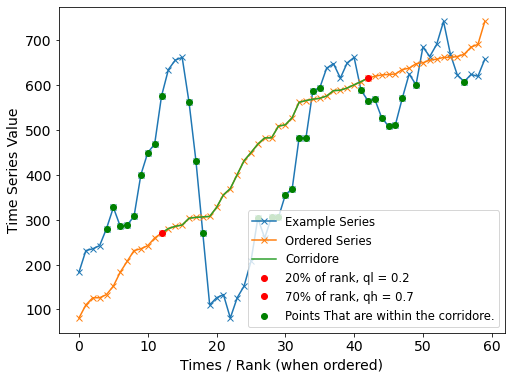

In [7]:
ql = 0.2
qh = 0.7
T = len(x[1])
sorted = np.sort(x[1])
figureCorridore = plt.figure(figsize = (8,6))
plt.plot(range(T),x[1],'x-', label = 'Example Series')
plt.plot(range(T), sorted,'x-', label = 'Ordered Series')
plt.plot(range(int(ql*T),int(qh*T)+1),sorted[int(ql*T):int(qh*T)+1], label = 'Corridore')
plt.plot(int(ql*T),sorted[int(ql*T)],'ro', label = '20% of rank, ql = 0.2',zorder = 20)
plt.plot(int(qh*T),sorted[int(qh*T)],'ro', label = '70% of rank, qh = 0.7',zorder = 20)
plt.xlabel('Times / Rank (when ordered)')
plt.ylabel('Time Series Value')

bin_cat = pd.qcut(x[1], [ql, qh], labels=False)
mask = bin_cat == 0
timesKept = np.arange(len(x[1]))[mask]

plt.scatter(timesKept,x[1][mask],color = 'g', label = 'Points That are within the corridore.',zorder = 5)
plt.legend(fontsize  ='small')
#plt.plot(np.sort(x[1][mask]))

## Why is this feature useful?

The 5 most important features use the quantile ranges  

qh --- ql  
1.0  -- 0  
0.4 -- 0  
1.0 -- 0.4  
1.0 -- 0.6  

The first one from 1 to 0 means the entire sample is used. The others could have issues because the signals are randomly placed in the samples. This means that the points of the sample that represent the signal might be completly ignored if they by chance dont fall within the corridore. 

Using the fist order difference will flatten any gradual change in the values whilst any steep change will have a big peak. When you look at the plot below you can see that the values of the origional sample gradually move up to the hight of the injected sine peak. This means a high value does not constitute a signal. When the first order difference are plotted the peak of the signal rises above the rest of the samples. Thus a signal is distinguishable simply because there is a value much higher than the others. The samples with a signal will have this dominating peak in the first order difference and thus the variance will be high. The variance will be higher for every sample with a signal and lower for every sample with out a signal. This make the samples easy to distinguish.

I am not sure how this would help distinguish between a positive or negative sine signal. As the variance would have a similar magnitude and can only be positive. I am not sure how changing the quartiles could help either.

3350.405630565929


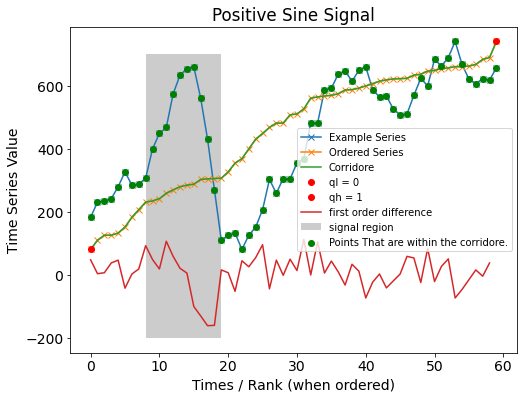

In [31]:
ql = 0
qh = 1
sample = 1
T = len(x[sample])
sorted = np.sort(x[sample])
figureCorridore = plt.figure(figsize = (8,6))
plt.title('Positive Sine Signal')
plt.plot(range(T),x[sample],'x-', label = 'Example Series')
plt.plot(range(T), sorted,'x-', label = 'Ordered Series')
plt.plot(range(T),sorted, label = 'Corridore')
plt.plot(0,sorted[0],'ro', label = 'ql = 0',zorder = 20)
plt.plot(T-1,sorted[T-1],'ro', label = 'qh = 1',zorder = 20)
start = 8
plt.fill_between(range(start,start+12),700,-200, facecolor='gray', alpha=0.4,label = 'signal region')
plt.xlabel('Times / Rank (when ordered)')
plt.ylabel('Time Series Value')

bin_cat = pd.qcut(x[sample], [ql, qh], labels=False)
mask = bin_cat == 0
timesKept = np.arange(len(x[sample]))[mask]

plt.scatter(timesKept,x[sample][mask],color = 'g', label = 'Points That are within the corridore.',zorder = 5)
div = np.diff(x[sample])
plt.plot(div, label = 'first order difference')

plt.legend(loc = 5,prop = {'size' : '10'})



print(np.var(div))
#plt.plot(np.sort(x[1][mask]))

2937.6340132145942


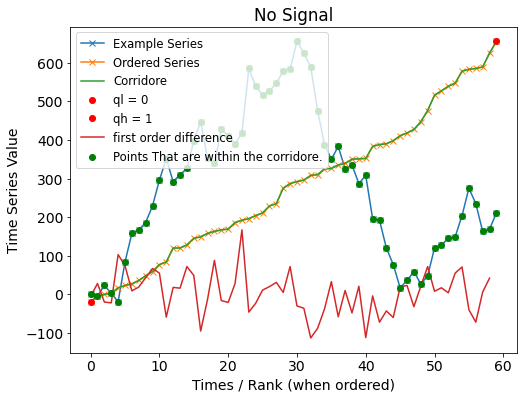

In [57]:
ql = 0
qh = 1
sample = 0
T = len(x[sample])
sorted = np.sort(x[sample])
figureCorridore = plt.figure(figsize = (8,6))
plt.title('No Signal')
plt.plot(range(T),x[sample],'x-', label = 'Example Series')
plt.plot(range(T), sorted,'x-', label = 'Ordered Series')
plt.plot(range(T),sorted, label = 'Corridore')
plt.plot(0,sorted[0],'ro', label = 'ql = 0',zorder = 20)
plt.plot(T-1,sorted[T-1],'ro', label = 'qh = 1',zorder = 20)
plt.xlabel('Times / Rank (when ordered)')
plt.ylabel('Time Series Value')

bin_cat = pd.qcut(x[sample], [ql, qh], labels=False)
mask = bin_cat == 0
timesKept = np.arange(len(x[sample]))[mask]

plt.scatter(timesKept,x[sample][mask],color = 'g', label = 'Points That are within the corridore.',zorder = 5)
div = np.diff(x[sample])
plt.plot(div, label = 'first order difference')

plt.legend(fontsize  ='small')



print(np.var(div))
#plt.plot(np.sort(x[1][mask]))

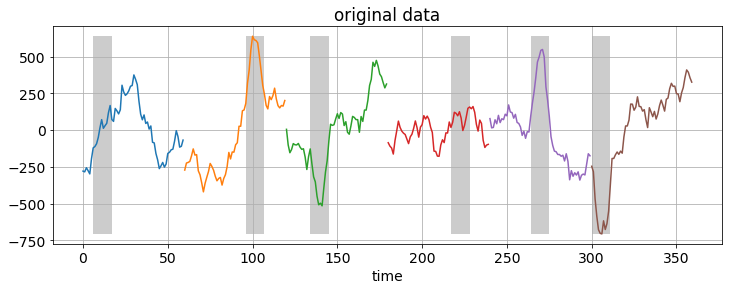

## Understanding the Sea Born Plot

First lets consider the non diagonal plots. There is a plot for every combination of features. The axis show the possible range od values each sample can have for a feature. The axis are shared amongst all of the plots. Each point represents a sample. The color represents which category the samples belong to. Plots whose positions mirror on the main diagonal are the same plot with the axis exchanges. It is clear to see that the features cause the samples to cluster into their distinct categories. This allows them to be distinguised from eachother. 

### Kernal Density Estimations
The diagonal plots are kernal density estimations. They are estimates of the probability density function of the data. A different kernal density plot is made for each category. A histogram of discrete bins would show similar infomation but the kernal density estimation aims to be continous. 

In particular they are *layered* kernal density estimations. This means they aim to show the distributions of all of the plots in that columb combined. 

The first columb shows feature 1 on the x axis and all the other features on the y axis. The kernal density estimation for this columb can only show the spread along the x axis. This shows that the red category and the yellow catefory are on top of eachother. Thus feature 1 is not sufficient to distinguish beteen the red and yellow categories. Although when it is combined with any of the other features there the red and yellow categories spread long this feature axis. This can be seen by looking at the other plots in the columb. 

If only choosing two features to use the best combination would be one where the clusters are seperated as much as possible, feature 2 and 3 are a bad combination whilst 4 and 2 could be a good combination.

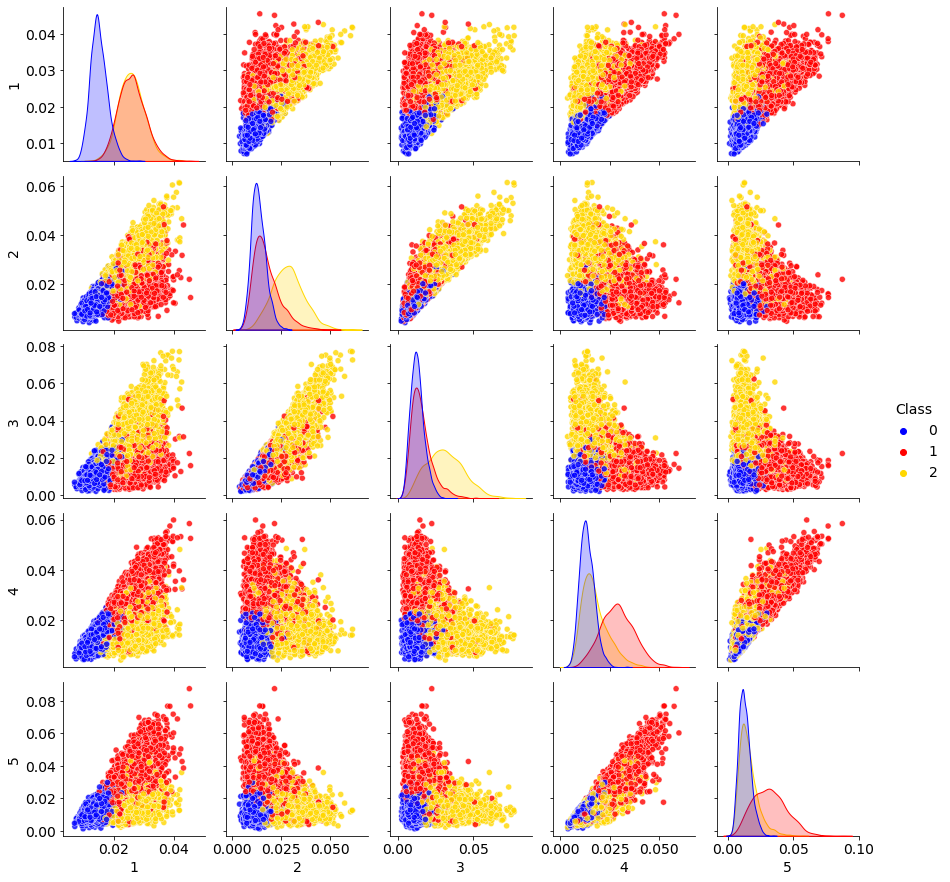

In [9]:
sns.pairplot(df,hue='Class',plot_kws=dict(alpha=0.8),palette=pal);

<a id ="fnn"></a>
# 1c) Feed Forward Neural Network (FNN)
<a href ="#contents">
<p style="text-align: right;">return to contents</p>
</a>

### Imports
https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from tsfresh import extract_features
from xgboost import XGBClassifier, plot_tree

%run plot.py

/home/theivan/miniconda3/envs/datascience/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Read data

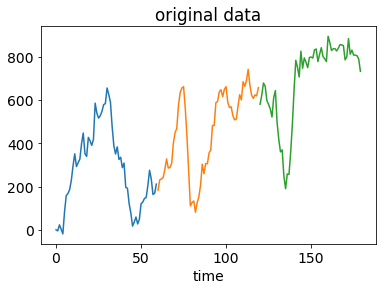

data:  10000


In [ ]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"original data")

# note: here it does not need to be converted to the 3-bit version, a label remains y[i]=0,1,2
y = np.loadtxt(fnamey, dtype=int)
n_class = 3    #  = len(np.unique(y))
print('data: ',N)

## TSFRESH: extract features

Input data format: DATAFRAME

first column $\to$ id of the sample 

second column $\to$  id of the time step

third column $\to$ value of the feature of _id_-sample at _id_-step

For more: https://tsfresh.readthedocs.io/en/latest/text/data_formats.html

In [ ]:
def get_df(x):
    '''Build input dataframe for given data series
    Input:
    var = array of time series, (#samples,time,1)
    Return:
    df = dataframe ready for features extraction
    '''
    
    #N = #samples, t = timesteps
    N, t = x.shape[0], x.shape[1]
    #build id columns
    id_col = np.repeat(np.arange(N),t)
    #build time columns
    time_col = np.tile(np.arange(t),N)
    #build var columns
    x_col = x.flatten()
      
    #build dict for df
    x_dict = {'id':id_col,'time':time_col,'value':x_col}
        
    #return dataframe
    return pd.DataFrame(x_dict)

In [ ]:
#get df
df = get_df(x) 

#check that last columns, if reshaped is equal to x
#df_to_array = df.values[:,-1].reshape(x.shape[0],x.shape[1])
#sum of different values: should be 0
#print('Differences:',np.sum(df_to_array != x))

df

,id,time,value
0,0,0,0.0
1,0,1,-5.0
2,0,2,23.0
3,0,3,3.0
4,0,4,-19.0
...,...,...,...
599995,9999,55,2977193.0
599996,9999,56,2977276.0
599997,9999,57,2977286.0
599998,9999,58,2977386.0


In [ ]:
#extract features
x_features = extract_features(
                            df, #our dataframe
                            column_id='id', #sample id, from 0 to N
                            column_sort='time', #timestep, from 0 to t
                            column_kind=None, #we have only one feature
                            column_value='value', #value of input 
                            n_jobs=4) #number of cores

Feature Extraction: 100%|███████████████████████| 20/20 [07:50<00:00, 23.50s/it]


In [ ]:
#look at x_features
x_features = pd.read_pickle('./DATA/tsfresh_features.pkl')

In [ ]:
#remove columns with NaN or inf
x_features.replace([np.inf, -np.inf], np.nan)
x_features = x_features.dropna(axis='columns')

In [ ]:
#look at clean x_features
x_features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,1.0,16750.0,6.729150e+06,43.101695,3.576271,0.405172,289.5,...,0.283936,0.424254,0.424254,0.980757,1.606551,2.560840,3.232518,3.608440,3.809279,5.945714e+02
1,1.0,0.0,0.0,1.0,27302.0,1.455619e+07,44.000000,8.033898,-0.086207,509.5,...,0.379535,0.379535,0.518700,1.107653,1.547018,2.436717,3.108691,3.462655,3.659720,6.811429e+02
2,1.0,0.0,0.0,1.0,41650.0,3.090479e+07,45.491525,2.576271,-0.862069,784.0,...,0.142506,0.379535,0.424254,1.107653,1.745508,2.930054,3.743700,4.007333,3.988984,8.632857e+02
3,1.0,0.0,0.0,1.0,37428.0,2.393510e+07,44.372881,-2.169492,1.008621,631.0,...,0.473981,0.687083,1.320351,2.757282,1.695334,2.879917,3.584589,3.871793,3.937640,7.844286e+02
4,1.0,0.0,0.0,1.0,58260.0,6.072359e+07,54.593220,10.728814,-0.422414,909.0,...,0.379535,0.424254,0.656671,0.838120,1.668815,2.785780,3.277698,3.575507,3.773917,1.389857e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,1.0,0.0,1.0,178577898.0,5.315011e+14,44.898305,3.813559,-0.232759,2976394.0,...,0.283936,0.424254,0.563420,1.134027,1.588719,2.476201,3.245121,3.619739,3.789900,2.976477e+06
9996,1.0,0.0,0.0,1.0,178600157.0,5.316336e+14,40.288136,10.694915,-0.758621,2976629.0,...,0.142506,0.283936,0.424254,1.237411,1.655861,2.603521,3.355240,3.786663,3.876606,2.977001e+06
9997,1.0,0.0,0.0,1.0,178618515.0,5.317429e+14,48.915254,-1.423729,-0.422414,2976910.5,...,0.379535,0.424254,0.656671,0.928839,1.657902,2.624445,3.267602,3.634172,3.876606,2.977446e+06
9998,1.0,0.0,0.0,1.0,178611894.0,5.317035e+14,57.677966,-0.762712,0.577586,2976930.0,...,0.457102,0.656671,0.838120,0.973558,1.643572,2.582843,3.294830,3.639092,3.757935,2.977054e+06


### Split train/val

In [ ]:
#split data into training and validation

perc_train=0.8
N_train = int(perc_train*N)
x_train = x_features[:N_train]
y_train = y[:N_train]
x_val = x_features[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  n_class=',n_class)

#rescale: in each feature, remove average and divide by std
if True:
    average = np.mean(x_train,axis=0)
    x_train -= average
    x_val -= average

    std = np.std(x_train,axis=0)
    x_train /= std
    x_val /= std

N_train= 8000   N_val= 2000   n_class= 3


In [ ]:
#look at x_train
x_train

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__mean_n_absolute_max__number_of_maxima_7
0,NaN,-0.154708,-0.153005,0.184733,-1.703066,-1.108771,-0.515260,-0.206340,0.652297,-1.703052,...,-0.172377,0.045427,-0.690931,-0.624611,-0.570059,-0.565770,-0.591592,-0.548545,-0.360190,-1.703072
1,NaN,-0.154708,-0.153005,0.184733,-1.702810,-1.108771,-0.375026,0.482945,-0.156879,-1.702733,...,0.595648,-0.224926,-0.240896,-0.330381,-1.379862,-1.320183,-1.203082,-1.400056,-1.572744,-1.702946
2,NaN,-0.154708,-0.153005,0.184733,-1.702463,-1.108771,-0.142186,-0.360970,-1.434525,-1.702334,...,-1.308607,-0.224926,-0.690931,-0.330381,1.320117,1.678281,1.932753,1.781336,1.096772,-1.702681
3,NaN,-0.154708,-0.153005,0.184733,-1.702565,-1.108771,-0.316816,-1.094810,1.646022,-1.702556,...,1.354415,1.634378,3.578956,3.494595,0.637623,1.373552,1.147021,0.989663,0.680497,-1.702796
4,NaN,-0.154708,-0.153005,0.184733,-1.702060,-1.108771,1.278669,0.899661,-0.710526,-1.702152,...,0.595648,0.045427,0.416532,-0.955344,0.276892,0.801398,-0.368483,-0.740902,-0.646887,-1.701916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,NaN,-0.154708,-0.153005,0.184733,1.719143,2.220055,-0.674015,0.606125,-0.795702,1.719150,...,-0.172377,1.078123,0.774532,1.464283,1.497332,1.542843,1.367656,1.486894,1.096772,1.718974
7996,NaN,-0.154708,-0.153005,0.184733,1.719262,2.220286,0.056257,-1.212749,1.191748,1.719238,...,1.354415,0.886762,0.629618,0.510979,-0.417495,-0.643237,-0.437074,-0.096451,0.472360,1.719221
7997,NaN,-0.154708,-0.153005,0.184733,1.719502,2.220754,1.286607,0.991391,-0.384016,1.719535,...,-1.308607,-1.657901,-1.359544,-0.576897,1.093746,1.090091,1.060842,0.786875,0.680497,1.719505
7998,NaN,-0.154708,-0.153005,0.184733,1.720210,2.222131,-0.684598,-0.557535,0.141238,1.720195,...,-0.172377,-0.802874,-0.690931,-0.641304,0.215449,0.318163,0.449603,0.400780,0.680497,1.720076


With the features extracted by tsfresh, train a standard (non-convolutional) feed
forward neural network (FFNN) and compare the performances with those of XGBoost. Than
keep only the most relevant features from XGBoost and train another FFNN with this smaller
set. Is the new FFNN working better than the one trained with all features?

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, Dense
from sklearn.preprocessing import OneHotEncoder
from keras.utils.np_utils import to_categorical

2022-04-01 16:32:36.506159: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### Cleaning training dataset

In [ ]:
x_train = x_train.drop(['value__variance_larger_than_standard_deviation'], axis=1) #Dropping the first columns because are all Nan

x_train_not_nan = x_train.dropna(axis=1)
y_train_one_hot = to_categorical(y_train, num_classes=3)

### FFNN definition

In [ ]:
#Defining the model, altered for new catagorical lables and for grid search
def init_model(optimizer='RMSprop',activation='relu', neurons=10, dropout_rate=0, hidden_layers=4, init_mode='glorot_normal'):
    #definition of the architecture
    L=450 #size of input data points
    seed = 12345
    #keras.utils.set_random_seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
    model = Sequential()
    model.add(Dense(L, input_shape=(L,), activation=activation))

    for i in range(hidden_layers):
        model.add(Dense(neurons, activation=activation, kernel_initializer = init_mode))
        model.add(Dropout(dropout_rate))


    model.add(Dense(3, activation='softmax'))

    # compile the model
    model.compile(loss='categorical_crossentropy',  #tf.keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

### gridsearch to find a good model

In [ ]:
model_gridsearch = KerasClassifier(build_fn=init_model, 
                        epochs=15,
                        batch_size=50, 
                        verbose=1)

optimizer = ['RMSprop', 'Adam', 'Nadam']
activation = ['relu', 'elu']
dropout_rate = [0,0.1,0.2]
hidden_layers = [4]
neurons = [20, 30 ,40]
batch_size = [20,50]
#init_mode = ['uniform', 'lecun_uniform', 'normal', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

param_grid = dict(optimizer=optimizer, batch_size=batch_size, activation=activation,dropout_rate=dropout_rate, hidden_layers=hidden_layers,neurons=neurons)
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)
grid_result = grid.fit(x_train_not_nan,y_train_one_hot)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


2022-04-01 16:34:14.581523: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-01 16:34:14.588087: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-01 16:34:14.608261: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-01 16:34:14.704234: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-01 16:34:16.264082: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-01 16:34:16.265040: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-01 16:34:16.286693: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
202

Epoch 1/15
300/300 [==============================] - 3s 6ms/step - loss: 0.3997 - accuracy: 0.8461
Epoch 2/15
300/300 [==============================] - 3s 6ms/step - loss: 0.3956 - accuracy: 0.8392
Epoch 2/15
300/300 [==============================] - 3s 6ms/step - loss: 0.4078 - accuracy: 0.8338
Epoch 2/15
300/300 [==============================] - 2s 6ms/step - loss: 0.1639 - accuracy: 0.9452
Epoch 3/15
300/300 [==============================] - 2s 6ms/step - loss: 0.1225 - accuracy: 0.9581
Epoch 4/15
300/300 [==============================] - 2s 6ms/step - loss: 0.1167 - accuracy: 0.9586
Epoch 4/15
300/300 [==============================] - 2s 6ms/step - loss: 0.1019 - accuracy: 0.9653
Epoch 4/15
300/300 [==============================] - 2s 6ms/step - loss: 0.1026 - accuracy: 0.9646
Epoch 5/15
300/300 [==============================] - 2s 6ms/step - loss: 0.1068 - accuracy: 0.9608
Epoch 5/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0969 - accuracy: 0.9710


100/100 [==============================] - 0s 2ms/step - loss: 0.6890 - accuracy: 0.9305
Epoch 1/15
300/300 [==============================] - 2s 5ms/step - loss: 0.4247 - accuracy: 0.8285
Epoch 2/15
300/300 [==============================] - 2s 5ms/step - loss: 0.4334 - accuracy: 0.8255
Epoch 2/15
300/300 [==============================] - 2s 5ms/step - loss: 0.4349 - accuracy: 0.8235
Epoch 2/15
300/300 [==============================] - 1s 5ms/step - loss: 0.1421 - accuracy: 0.9532
Epoch 3/15
300/300 [==============================] - 1s 5ms/step - loss: 0.1526 - accuracy: 0.9492
Epoch 3/15
300/300 [==============================] - 2s 5ms/step - loss: 0.1652 - accuracy: 0.9448
Epoch 3/15
300/300 [==============================] - 1s 5ms/step - loss: 0.1378 - accuracy: 0.9507
Epoch 3/15
300/300 [==============================] - 1s 5ms/step - loss: 0.1047 - accuracy: 0.9675
Epoch 4/15
300/300 [==============================] - 2s 5ms/step - loss: 0.1000 - accuracy: 0.9654
Epoch 4/15


300/300 [==============================] - 3s 10ms/step - loss: 0.0202 - accuracy: 0.9935
Epoch 15/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0188 - accuracy: 0.9946
Epoch 15/15
300/300 [==============================] - 3s 9ms/step - loss: 0.0210 - accuracy: 0.9934
Epoch 15/15
100/100 [==============================] - 0s 2ms/step - loss: 0.3583 - accuracy: 0.9345
Epoch 1/15
300/300 [==============================] - 3s 6ms/step - loss: 0.4043 - accuracy: 0.8339
Epoch 2/15
300/300 [==============================] - 3s 6ms/step - loss: 0.4059 - accuracy: 0.8376
Epoch 2/15
300/300 [==============================] - 2s 6ms/step - loss: 0.1437 - accuracy: 0.9537
Epoch 3/15
300/300 [==============================] - 2s 6ms/step - loss: 0.1266 - accuracy: 0.9567
Epoch 4/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0896 - accuracy: 0.9680
Epoch 5/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0594 - accuracy: 0.9845
Epoch 

300/300 [==============================] - 2s 5ms/step - loss: 0.0277 - accuracy: 0.9901
Epoch 12/15
300/300 [==============================] - 1s 5ms/step - loss: 0.0271 - accuracy: 0.9924
Epoch 12/15
300/300 [==============================] - 1s 5ms/step - loss: 0.0220 - accuracy: 0.9937
Epoch 13/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0232 - accuracy: 0.9932
Epoch 13/15
300/300 [==============================] - 1s 5ms/step - loss: 0.0237 - accuracy: 0.9898
Epoch 14/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0422 - accuracy: 0.9871
Epoch 13/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0161 - accuracy: 0.9952
Epoch 14/15
300/300 [==============================] - 1s 5ms/step - loss: 0.0223 - accuracy: 0.9931
Epoch 15/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0199 - accuracy: 0.9944
Epoch 14/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0242 - accuracy: 0.9926
Ep

300/300 [==============================] - 3s 9ms/step - loss: 0.0284 - accuracy: 0.9906
Epoch 11/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0271 - accuracy: 0.9923
Epoch 12/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0369 - accuracy: 0.9887
Epoch 12/15
300/300 [==============================] - 3s 9ms/step - loss: 0.0163 - accuracy: 0.9939
Epoch 13/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0498 - accuracy: 0.9871
Epoch 13/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0316 - accuracy: 0.9899
Epoch 13/15
300/300 [==============================] - 3s 9ms/step - loss: 0.0255 - accuracy: 0.9917
Epoch 14/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0401 - accuracy: 0.9856
Epoch 14/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0105 - accuracy: 0.9973
Epoch 14/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0205 - accuracy: 0.

300/300 [==============================] - 2s 6ms/step - loss: 0.0269 - accuracy: 0.9926
Epoch 12/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0358 - accuracy: 0.9896
Epoch 12/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0362 - accuracy: 0.9871
Epoch 13/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0337 - accuracy: 0.9892
Epoch 13/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0216 - accuracy: 0.9936
Epoch 14/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0296 - accuracy: 0.9930
Epoch 14/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0255 - accuracy: 0.9904
Epoch 15/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0263 - accuracy: 0.9924
Epoch 14/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0238 - accuracy: 0.9955
Epoch 15/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0299 - accuracy: 0.9937
Ep

300/300 [==============================] - 2s 5ms/step - loss: 0.0281 - accuracy: 0.9911
Epoch 10/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0347 - accuracy: 0.9873
Epoch 12/15
300/300 [==============================] - 1s 5ms/step - loss: 0.0587 - accuracy: 0.9822
Epoch 12/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0200 - accuracy: 0.9931
Epoch 11/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0226 - accuracy: 0.9929
Epoch 13/15
300/300 [==============================] - 1s 5ms/step - loss: 0.0232 - accuracy: 0.9910
Epoch 13/15
300/300 [==============================] - 1s 5ms/step - loss: 0.0370 - accuracy: 0.9878
Epoch 15/15
300/300 [==============================] - 1s 4ms/step - loss: 0.0192 - accuracy: 0.9937
Epoch 15/15
100/100 [==============================] - 0s 2ms/step - loss: 0.3878 - accuracy: 0.9415
Epoch 1/15
300/300 [==============================] - 4s 7ms/step - loss: 0.3958 - accuracy: 0.8478
Epo

300/300 [==============================] - 3s 10ms/step - loss: 0.0429 - accuracy: 0.9859
Epoch 8/15
300/300 [==============================] - 3s 11ms/step - loss: 0.0355 - accuracy: 0.9872
Epoch 10/15
300/300 [==============================] - 3s 11ms/step - loss: 0.0367 - accuracy: 0.9886
Epoch 10/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0237 - accuracy: 0.9940
Epoch 11/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0252 - accuracy: 0.9900
Epoch 13/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0225 - accuracy: 0.9913
Epoch 14/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0135 - accuracy: 0.9946
Epoch 15/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0172 - accuracy: 0.9943
Epoch 14/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0296 - accuracy: 0.9923
Epoch 15/15
100/100 [==============================] - 0s 1ms/step - loss: 0.4270 - accuracy: 0

300/300 [==============================] - 2s 5ms/step - loss: 0.1178 - accuracy: 0.9566
Epoch 6/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0954 - accuracy: 0.9694
Epoch 8/15
300/300 [==============================] - 1s 5ms/step - loss: 0.0882 - accuracy: 0.9697
Epoch 8/15
300/300 [==============================] - 1s 5ms/step - loss: 0.1121 - accuracy: 0.9647
Epoch 7/15
300/300 [==============================] - 2s 6ms/step - loss: 0.1091 - accuracy: 0.9651
Epoch 6/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0822 - accuracy: 0.9705
Epoch 9/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0522 - accuracy: 0.9822
Epoch 10/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0802 - accuracy: 0.9721
Epoch 9/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0690 - accuracy: 0.9777
Epoch 8/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0571 - accuracy: 0.9815
Epoch 11/1

300/300 [==============================] - 2s 7ms/step - loss: 0.1680 - accuracy: 0.9486
Epoch 4/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0877 - accuracy: 0.9749
Epoch 6/15
300/300 [==============================] - 2s 7ms/step - loss: 0.1489 - accuracy: 0.9536
Epoch 5/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0891 - accuracy: 0.9727
Epoch 7/15
300/300 [==============================] - 2s 7ms/step - loss: 0.1081 - accuracy: 0.9664
Epoch 6/15
300/300 [==============================] - 2s 7ms/step - loss: 0.1194 - accuracy: 0.9681
Epoch 6/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0833 - accuracy: 0.9768
Epoch 8/15
300/300 [==============================] - 2s 7ms/step - loss: 0.1179 - accuracy: 0.9603
Epoch 5/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0967 - accuracy: 0.9710
Epoch 8/15
300/300 [==============================] - 2s 8ms/step - loss: 0.0899 - accuracy: 0.9783
Epoch 8/15


300/300 [==============================] - 1s 4ms/step - loss: 0.1274 - accuracy: 0.9562
Epoch 5/15
300/300 [==============================] - 1s 4ms/step - loss: 0.2150 - accuracy: 0.9317
Epoch 3/15
300/300 [==============================] - 2s 5ms/step - loss: 0.1405 - accuracy: 0.9585
Epoch 4/15
300/300 [==============================] - 1s 5ms/step - loss: 0.0846 - accuracy: 0.9748
Epoch 6/15
300/300 [==============================] - 2s 5ms/step - loss: 0.1538 - accuracy: 0.9498
Epoch 4/15
300/300 [==============================] - 3s 5ms/step - loss: 0.5267 - accuracy: 0.7780
Epoch 2/15
300/300 [==============================] - 2s 5ms/step - loss: 0.1372 - accuracy: 0.9533
Epoch 5/15
300/300 [==============================] - 2s 5ms/step - loss: 0.1028 - accuracy: 0.9663
Epoch 6/15
300/300 [==============================] - 1s 5ms/step - loss: 0.1007 - accuracy: 0.9637
Epoch 6/15
300/300 [==============================] - 1s 5ms/step - loss: 0.1445 - accuracy: 0.9554
Epoch 4/15


300/300 [==============================] - 5s 8ms/step - loss: 0.5263 - accuracy: 0.7861
Epoch 2/15
300/300 [==============================] - 3s 9ms/step - loss: 0.1201 - accuracy: 0.9595
Epoch 5/15
300/300 [==============================] - 7s 10ms/step - loss: 0.5181 - accuracy: 0.7865
Epoch 2/15
300/300 [==============================] - 3s 10ms/step - loss: 0.1809 - accuracy: 0.9347
Epoch 3/15
300/300 [==============================] - 3s 9ms/step - loss: 0.0776 - accuracy: 0.9734
Epoch 7/15
300/300 [==============================] - 3s 9ms/step - loss: 0.1285 - accuracy: 0.9596
Epoch 5/15
300/300 [==============================] - 3s 10ms/step - loss: 0.1238 - accuracy: 0.9587
Epoch 5/15
300/300 [==============================] - 3s 10ms/step - loss: 0.1114 - accuracy: 0.9634
Epoch 6/15
300/300 [==============================] - 3s 10ms/step - loss: 0.1037 - accuracy: 0.9657
Epoch 6/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0572 - accuracy: 0.9817
Epoch

300/300 [==============================] - 2s 5ms/step - loss: 0.0463 - accuracy: 0.9890
Epoch 15/15
300/300 [==============================] - 3s 4ms/step - loss: 0.5031 - accuracy: 0.7932
Epoch 2/15
300/300 [==============================] - 1s 4ms/step - loss: 0.1868 - accuracy: 0.9362
Epoch 3/15
300/300 [==============================] - 1s 3ms/step - loss: 0.1321 - accuracy: 0.9572
Epoch 4/15
300/300 [==============================] - 1s 4ms/step - loss: 0.1128 - accuracy: 0.9613
Epoch 5/15
300/300 [==============================] - 2s 5ms/step - loss: 0.2134 - accuracy: 0.9265
Epoch 3/15
300/300 [==============================] - 1s 5ms/step - loss: 0.1491 - accuracy: 0.9529
Epoch 4/15
300/300 [==============================] - 4s 5ms/step - loss: 0.4929 - accuracy: 0.8158
Epoch 2/15
300/300 [==============================] - 1s 5ms/step - loss: 0.0885 - accuracy: 0.9660
Epoch 7/15
300/300 [==============================] - 2s 5ms/step - loss: 0.1784 - accuracy: 0.9395
Epoch 3/15

300/300 [==============================] - 3s 9ms/step - loss: 0.0316 - accuracy: 0.9903
Epoch 14/15
300/300 [==============================] - 2s 8ms/step - loss: 0.0276 - accuracy: 0.9927
Epoch 13/15
300/300 [==============================] - 2s 8ms/step - loss: 0.0350 - accuracy: 0.9892
Epoch 15/15
300/300 [==============================] - 2s 8ms/step - loss: 0.0359 - accuracy: 0.9900
Epoch 14/15
300/300 [==============================] - 5s 6ms/step - loss: 0.6621 - accuracy: 0.7079
Epoch 2/15
300/300 [==============================] - 1s 4ms/step - loss: 0.2848 - accuracy: 0.9037
Epoch 3/15
300/300 [==============================] - 1s 4ms/step - loss: 0.2058 - accuracy: 0.9401
Epoch 4/15
300/300 [==============================] - 4s 6ms/step - loss: 0.6892 - accuracy: 0.6901
Epoch 2/15
300/300 [==============================] - 4s 6ms/step - loss: 0.6872 - accuracy: 0.6794
Epoch 2/15
300/300 [==============================] - 2s 6ms/step - loss: 0.3259 - accuracy: 0.8956
Epoch 3

300/300 [==============================] - 2s 6ms/step - loss: 0.0737 - accuracy: 0.9768
Epoch 13/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0909 - accuracy: 0.9814
Epoch 13/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0817 - accuracy: 0.9755
Epoch 12/15
300/300 [==============================] - 2s 6ms/step - loss: 0.1082 - accuracy: 0.9800
Epoch 13/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0780 - accuracy: 0.9819
Epoch 15/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0763 - accuracy: 0.9818
Epoch 15/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0735 - accuracy: 0.9803
Epoch 15/15
300/300 [==============================] - 1s 4ms/step - loss: 0.3112 - accuracy: 0.8906
Epoch 3/15
300/300 [==============================] - 1s 4ms/step - loss: 0.2124 - accuracy: 0.9284
Epoch 4/15
300/300 [==============================] - 2s 4ms/step - loss: 0.7208 - accuracy: 0.6528
Epoc

300/300 [==============================] - 2s 5ms/step - loss: 0.0984 - accuracy: 0.9706
Epoch 12/15
300/300 [==============================] - 1s 5ms/step - loss: 0.0525 - accuracy: 0.9835
Epoch 11/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0912 - accuracy: 0.9743
Epoch 13/15
300/300 [==============================] - 1s 4ms/step - loss: 0.0786 - accuracy: 0.9747
Epoch 13/15
300/300 [==============================] - 1s 5ms/step - loss: 0.0886 - accuracy: 0.9699
Epoch 12/15
300/300 [==============================] - 1s 5ms/step - loss: 0.0598 - accuracy: 0.9819
Epoch 14/15
300/300 [==============================] - 1s 4ms/step - loss: 0.0757 - accuracy: 0.9745
Epoch 14/15
300/300 [==============================] - 1s 4ms/step - loss: 0.0559 - accuracy: 0.9822
Epoch 13/15
300/300 [==============================] - 1s 4ms/step - loss: 0.0747 - accuracy: 0.9776
Epoch 15/15
300/300 [==============================] - 1s 4ms/step - loss: 0.0779 - accuracy: 0.9786
Ep

300/300 [==============================] - 3s 9ms/step - loss: 0.0709 - accuracy: 0.9760
Epoch 11/15
300/300 [==============================] - 2s 8ms/step - loss: 0.0673 - accuracy: 0.9805
Epoch 12/15
300/300 [==============================] - 2s 8ms/step - loss: 0.0806 - accuracy: 0.9769
Epoch 13/15
300/300 [==============================] - 2s 8ms/step - loss: 0.0620 - accuracy: 0.9786
Epoch 15/15
300/300 [==============================] - 3s 8ms/step - loss: 0.0624 - accuracy: 0.9778
Epoch 15/15
300/300 [==============================] - 3s 9ms/step - loss: 0.0764 - accuracy: 0.9794
Epoch 2/15
300/300 [==============================] - 1s 5ms/step - loss: 0.1816 - accuracy: 0.9412
Epoch 4/15
300/300 [==============================] - 1s 4ms/step - loss: 0.1550 - accuracy: 0.9511
Epoch 5/15
300/300 [==============================] - 2s 5ms/step - loss: 0.2718 - accuracy: 0.9124
Epoch 3/15
300/300 [==============================] - 2s 6ms/step - loss: 0.1192 - accuracy: 0.9646
Epoch 

300/300 [==============================] - 2s 7ms/step - loss: 0.0862 - accuracy: 0.9756
Epoch 12/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0901 - accuracy: 0.9780
Epoch 10/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0939 - accuracy: 0.9775
Epoch 11/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0761 - accuracy: 0.9814
Epoch 13/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0630 - accuracy: 0.9847
Epoch 11/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0620 - accuracy: 0.9829
Epoch 14/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0665 - accuracy: 0.9842
Epoch 12/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0821 - accuracy: 0.9826
Epoch 13/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0677 - accuracy: 0.9850
Epoch 13/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0669 - accuracy: 0.9835
Ep

300/300 [==============================] - 3s 10ms/step - loss: 0.0776 - accuracy: 0.9746
Epoch 9/15
300/300 [==============================] - 3s 9ms/step - loss: 0.0762 - accuracy: 0.9744
Epoch 12/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0708 - accuracy: 0.9779
Epoch 10/15
300/300 [==============================] - 3s 11ms/step - loss: 0.0529 - accuracy: 0.9832
Epoch 13/15
300/300 [==============================] - 3s 9ms/step - loss: 0.0406 - accuracy: 0.9877
Epoch 11/15
300/300 [==============================] - 3s 9ms/step - loss: 0.0802 - accuracy: 0.9769
Epoch 11/15
300/300 [==============================] - 3s 8ms/step - loss: 0.0519 - accuracy: 0.9835
Epoch 14/15
300/300 [==============================] - 2s 8ms/step - loss: 0.0546 - accuracy: 0.9849
Epoch 12/15
300/300 [==============================] - 2s 8ms/step - loss: 0.0610 - accuracy: 0.9823
Epoch 15/15
300/300 [==============================] - 3s 9ms/step - loss: 0.0643 - accuracy: 0.9816


300/300 [==============================] - 2s 5ms/step - loss: 0.0995 - accuracy: 0.9705
Epoch 8/15
300/300 [==============================] - 1s 5ms/step - loss: 0.0722 - accuracy: 0.9781
Epoch 12/15
300/300 [==============================] - 1s 5ms/step - loss: 0.0956 - accuracy: 0.9685
Epoch 7/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0545 - accuracy: 0.9850
Epoch 15/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0876 - accuracy: 0.9708
Epoch 9/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0648 - accuracy: 0.9791
Epoch 13/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0705 - accuracy: 0.9773
Epoch 10/15
300/300 [==============================] - 1s 5ms/step - loss: 0.0482 - accuracy: 0.9842
Epoch 14/15
300/300 [==============================] - 1s 5ms/step - loss: 0.0690 - accuracy: 0.9768
Epoch 9/15
300/300 [==============================] - 1s 4ms/step - loss: 0.0606 - accuracy: 0.9807
Epoch 

300/300 [==============================] - 3s 10ms/step - loss: 0.0759 - accuracy: 0.9742
Epoch 9/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0482 - accuracy: 0.9881
Epoch 13/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0868 - accuracy: 0.9748
Epoch 8/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0716 - accuracy: 0.9790
Epoch 12/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0824 - accuracy: 0.9802
Epoch 13/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0635 - accuracy: 0.9803
Epoch 11/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0580 - accuracy: 0.9832
Epoch 12/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0679 - accuracy: 0.9821
Epoch 15/15
300/300 [==============================] - 2s 8ms/step - loss: 0.0640 - accuracy: 0.9801
Epoch 13/15
300/300 [==============================] - 3s 9ms/step - loss: 0.0529 - accuracy: 0.9

/home/theivan/miniconda3/envs/datascience/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


300/300 [==============================] - 2s 7ms/step - loss: 0.0386 - accuracy: 0.9884
Epoch 14/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0401 - accuracy: 0.9876
Epoch 13/15
145/300 [=============>................] - ETA: 0s - loss: 0.0322 - accuracy: 0.9890

2022-04-01 16:49:47.039063: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


300/300 [==============================] - 2s 6ms/step - loss: 0.0435 - accuracy: 0.9861
Epoch 15/15
120/120 [==============================] - 4s 8ms/step - loss: 0.4392 - accuracy: 0.8156
Epoch 2/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0345 - accuracy: 0.9915
Epoch 15/15
 93/120 [======================>.......] - ETA: 0s - loss: 0.1617 - accuracy: 0.9424

2022-04-01 16:49:50.771573: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-01 16:49:50.773890: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-01 16:49:50.846259: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-01 16:49:50.846388: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (theivan-X756UXK): /proc/driver/nvidia/version does not exist
2022-04-01 16:49:50.846776: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler fl

120/120 [==============================] - 1s 6ms/step - loss: 0.1594 - accuracy: 0.9432
Epoch 3/15
120/120 [==============================] - 1s 5ms/step - loss: 0.1094 - accuracy: 0.9615
Epoch 4/15
 12/120 [==>...........................] - ETA: 0s - loss: 0.1019 - accuracy: 0.9580

2022-04-01 16:49:51.673212: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-01 16:49:51.677028: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz


120/120 [==============================] - 1s 5ms/step - loss: 0.0601 - accuracy: 0.9792
Epoch 6/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0613 - accuracy: 0.9790
Epoch 7/15
  1/120 [..............................] - ETA: 4:25 - loss: 1.0849 - accuracy: 0.4200

2022-04-01 16:49:53.843761: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


120/120 [==============================] - 1s 5ms/step - loss: 0.0540 - accuracy: 0.9795
Epoch 8/15
120/120 [==============================] - 3s 6ms/step - loss: 0.4515 - accuracy: 0.8288
Epoch 2/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0440 - accuracy: 0.9886
Epoch 9/15
120/120 [==============================] - 1s 6ms/step - loss: 0.1389 - accuracy: 0.9519
Epoch 3/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0265 - accuracy: 0.9903
Epoch 10/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0979 - accuracy: 0.9646
Epoch 4/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0797 - accuracy: 0.9699
Epoch 5/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0265 - accuracy: 0.9916
Epoch 12/15
120/120 [==============================] - 3s 7ms/step - loss: 0.4553 - accuracy: 0.8187
Epoch 2/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0550 - accuracy: 0.9837
Epoch 6/1

2022-04-01 16:49:59.285595: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-01 16:49:59.290124: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-01 16:49:59.385257: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-01 16:49:59.385737: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (theivan-X756UXK): /proc/driver/nvidia/version does not exist
2022-04-01 16:49:59.386406: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler fl

120/120 [==============================] - 1s 6ms/step - loss: 0.0710 - accuracy: 0.9756
Epoch 5/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0424 - accuracy: 0.9852
Epoch 6/15
 10/120 [=>............................] - ETA: 0s - loss: 0.0400 - accuracy: 0.9869

2022-04-01 16:50:00.607262: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-01 16:50:00.625220: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz


120/120 [==============================] - 1s 6ms/step - loss: 0.0212 - accuracy: 0.9924
Epoch 10/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0398 - accuracy: 0.9868
Epoch 7/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0219 - accuracy: 0.9930
Epoch 11/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0159 - accuracy: 0.9944
Epoch 12/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0180 - accuracy: 0.9952
Epoch 9/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0164 - accuracy: 0.9935
Epoch 13/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0203 - accuracy: 0.9937
Epoch 10/15
120/120 [==============================] - 3s 7ms/step - loss: 0.4414 - accuracy: 0.8112
Epoch 2/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0158 - accuracy: 0.9946
Epoch 11/15
120/120 [==============================] - 1s 6ms/step - loss: 0.1576 - accuracy: 0.9488
Epoch

120/120 [==============================] - 1s 5ms/step - loss: 0.0515 - accuracy: 0.9822
Epoch 7/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0423 - accuracy: 0.9851
Epoch 10/15
120/120 [==============================] - 1s 4ms/step - loss: 0.0461 - accuracy: 0.9830
Epoch 8/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0120 - accuracy: 0.9960
Epoch 11/15
120/120 [==============================] - 0s 4ms/step - loss: 0.0326 - accuracy: 0.9891
Epoch 12/15
120/120 [==============================] - 0s 4ms/step - loss: 0.0429 - accuracy: 0.9864
Epoch 10/15
120/120 [==============================] - 0s 4ms/step - loss: 0.0169 - accuracy: 0.9948
Epoch 13/15
120/120 [==============================] - 1s 4ms/step - loss: 0.0251 - accuracy: 0.9921
Epoch 11/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0042 - accuracy: 0.9996
Epoch 14/15
120/120 [==============================] - 2s 6ms/step - loss: 0.5405 - accuracy: 0.7719
Epoc

120/120 [==============================] - 1s 9ms/step - loss: 0.0341 - accuracy: 0.9884
Epoch 10/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0123 - accuracy: 0.9967
Epoch 11/15
120/120 [==============================] - 1s 10ms/step - loss: 0.0179 - accuracy: 0.9945
Epoch 10/15
120/120 [==============================] - 7s 9ms/step - loss: 0.5175 - accuracy: 0.7945
Epoch 2/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0267 - accuracy: 0.9920
Epoch 11/15
120/120 [==============================] - 1s 10ms/step - loss: 0.0082 - accuracy: 0.9972
Epoch 12/15
120/120 [==============================] - 1s 9ms/step - loss: 0.1215 - accuracy: 0.9549
Epoch 3/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0334 - accuracy: 0.9908
Epoch 12/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0187 - accuracy: 0.9920
Epoch 13/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0778 - accuracy: 0.9737
Ep

120/120 [==============================] - 1s 7ms/step - loss: 0.0219 - accuracy: 0.9930
Epoch 11/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0289 - accuracy: 0.9901
Epoch 11/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0279 - accuracy: 0.9935
Epoch 13/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0199 - accuracy: 0.9921
Epoch 13/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0149 - accuracy: 0.9956
Epoch 14/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0152 - accuracy: 0.9962
Epoch 14/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0205 - accuracy: 0.9937
Epoch 15/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0754 - accuracy: 0.9728
Epoch 5/15
120/120 [==============================] - 1s 5ms/step - loss: 0.1393 - accuracy: 0.9514
Epoch 3/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0413 - accuracy: 0.9855
Epoc

120/120 [==============================] - 1s 6ms/step - loss: 0.0406 - accuracy: 0.9896
Epoch 8/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0318 - accuracy: 0.9888
Epoch 10/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0341 - accuracy: 0.9878
Epoch 9/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0298 - accuracy: 0.9906
Epoch 10/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0235 - accuracy: 0.9924
Epoch 12/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0166 - accuracy: 0.9950
Epoch 11/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0403 - accuracy: 0.9881
Epoch 13/15
120/120 [==============================] - 0s 4ms/step - loss: 0.0368 - accuracy: 0.9869
Epoch 14/15
120/120 [==============================] - 1s 4ms/step - loss: 0.0210 - accuracy: 0.9933
Epoch 13/15
120/120 [==============================] - 0s 4ms/step - loss: 0.0115 - accuracy: 0.9971
Epoc

120/120 [==============================] - 1s 9ms/step - loss: 0.0171 - accuracy: 0.9935
Epoch 12/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0320 - accuracy: 0.9883
Epoch 10/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0241 - accuracy: 0.9909
Epoch 13/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0132 - accuracy: 0.9957
Epoch 14/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0153 - accuracy: 0.9944
Epoch 12/15
120/120 [==============================] - 1s 10ms/step - loss: 0.0318 - accuracy: 0.9910
Epoch 11/15
120/120 [==============================] - 6s 10ms/step - loss: 0.5247 - accuracy: 0.7711
Epoch 2/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0244 - accuracy: 0.9937
Epoch 13/15
120/120 [==============================] - 1s 9ms/step - loss: 0.1189 - accuracy: 0.9557
Epoch 3/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0146 - accuracy: 0.9952
Ep

120/120 [==============================] - 1s 11ms/step - loss: 0.0060 - accuracy: 0.9983
Epoch 15/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0577 - accuracy: 0.9804
Epoch 7/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0104 - accuracy: 0.9968
Epoch 12/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0331 - accuracy: 0.9896
Epoch 9/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0216 - accuracy: 0.9927
Epoch 13/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0321 - accuracy: 0.9895
Epoch 9/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0243 - accuracy: 0.9918
Epoch 10/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0130 - accuracy: 0.9963
Epoch 14/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0391 - accuracy: 0.9899
Epoch 10/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0308 - accuracy: 0.9920
Epoc

120/120 [==============================] - 1s 7ms/step - loss: 0.0392 - accuracy: 0.9848
Epoch 8/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0405 - accuracy: 0.9882
Epoch 8/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0326 - accuracy: 0.9884
Epoch 13/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0300 - accuracy: 0.9888
Epoch 10/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0275 - accuracy: 0.9899
Epoch 10/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0156 - accuracy: 0.9952
Epoch 11/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0224 - accuracy: 0.9916
Epoch 15/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0239 - accuracy: 0.9946
Epoch 11/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0394 - accuracy: 0.9871
Epoch 12/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0349 - accuracy: 0.9889
Epoc

120/120 [==============================] - 1s 10ms/step - loss: 0.0436 - accuracy: 0.9831
Epoch 6/15
120/120 [==============================] - 1s 10ms/step - loss: 0.0187 - accuracy: 0.9943
Epoch 10/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0550 - accuracy: 0.9802
Epoch 7/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0188 - accuracy: 0.9932
Epoch 7/15
120/120 [==============================] - 1s 10ms/step - loss: 0.0320 - accuracy: 0.9895
Epoch 8/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0140 - accuracy: 0.9964
Epoch 8/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0109 - accuracy: 0.9953
Epoch 9/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0413 - accuracy: 0.9870
Epoch 10/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0185 - accuracy: 0.9937
Epoch 14/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0200 - accuracy: 0.9931
Epoch

120/120 [==============================] - 1s 8ms/step - loss: 0.0496 - accuracy: 0.9849
Epoch 10/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0902 - accuracy: 0.9710
Epoch 8/15
120/120 [==============================] - 1s 8ms/step - loss: 0.1009 - accuracy: 0.9707
Epoch 7/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0533 - accuracy: 0.9857
Epoch 14/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0946 - accuracy: 0.9679
Epoch 9/15
120/120 [==============================] - 1s 11ms/step - loss: 0.0032 - accuracy: 0.9989
Epoch 15/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0696 - accuracy: 0.9774
Epoch 9/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0669 - accuracy: 0.9786
Epoch 10/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0740 - accuracy: 0.9789
Epoch 11/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0335 - accuracy: 0.9888
Epoch

2022-04-01 16:53:02.226205: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


120/120 [==============================] - 0s 3ms/step - loss: 0.0795 - accuracy: 0.9762
Epoch 7/15
120/120 [==============================] - 0s 3ms/step - loss: 0.0725 - accuracy: 0.9748
Epoch 8/15
120/120 [==============================] - 0s 4ms/step - loss: 0.0932 - accuracy: 0.9680
Epoch 9/15
120/120 [==============================] - 1s 4ms/step - loss: 0.0577 - accuracy: 0.9819
Epoch 10/15
120/120 [==============================] - 3s 8ms/step - loss: 0.6552 - accuracy: 0.7043
Epoch 2/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0620 - accuracy: 0.9782
Epoch 11/15
120/120 [==============================] - 4s 9ms/step - loss: 0.6514 - accuracy: 0.7002
Epoch 2/15
120/120 [==============================] - 1s 9ms/step - loss: 0.2302 - accuracy: 0.9252
Epoch 3/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0485 - accuracy: 0.9872
Epoch 12/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0471 - accuracy: 0.9837
Epoch 13

2022-04-01 16:53:06.941778: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-01 16:53:06.944560: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-01 16:53:07.021214: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-01 16:53:07.021269: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (theivan-X756UXK): /proc/driver/nvidia/version does not exist
2022-04-01 16:53:07.021660: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler fl

120/120 [==============================] - 1s 6ms/step - loss: 0.0262 - accuracy: 0.9908
Epoch 15/15
 99/120 [=======================>......] - ETA: 0s - loss: 0.0319 - accuracy: 0.9898

2022-04-01 16:53:07.682297: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-01 16:53:07.683346: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz


120/120 [==============================] - 1s 6ms/step - loss: 0.0327 - accuracy: 0.9895
Epoch 5/15
120/120 [==============================] - 1s 9ms/step - loss: 0.1019 - accuracy: 0.9654
Epoch 6/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0947 - accuracy: 0.9697
Epoch 6/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0797 - accuracy: 0.9779
Epoch 7/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0949 - accuracy: 0.9701
Epoch 7/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0679 - accuracy: 0.9755
Epoch 8/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0826 - accuracy: 0.9711
Epoch 8/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0682 - accuracy: 0.9775
Epoch 9/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0656 - accuracy: 0.9768
Epoch 9/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0447 - accuracy: 0.9862
Epoch 10/15

120/120 [==============================] - 1s 8ms/step - loss: 0.0417 - accuracy: 0.9866
Epoch 13/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0795 - accuracy: 0.9764
Epoch 8/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0668 - accuracy: 0.9739
Epoch 9/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0433 - accuracy: 0.9852
Epoch 10/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0683 - accuracy: 0.9791
Epoch 10/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0345 - accuracy: 0.9875
Epoch 15/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0350 - accuracy: 0.9892
Epoch 11/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0559 - accuracy: 0.9821
Epoch 11/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0422 - accuracy: 0.9823
Epoch 12/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0362 - accuracy: 0.9851
Epoc

120/120 [==============================] - 1s 11ms/step - loss: 0.0802 - accuracy: 0.9766
Epoch 6/15
120/120 [==============================] - 1s 10ms/step - loss: 0.0903 - accuracy: 0.9712
Epoch 6/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0903 - accuracy: 0.9712
Epoch 7/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0819 - accuracy: 0.9746
Epoch 7/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0815 - accuracy: 0.9750
Epoch 8/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0647 - accuracy: 0.9786
Epoch 8/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0577 - accuracy: 0.9806
Epoch 9/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0554 - accuracy: 0.9812
Epoch 9/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0444 - accuracy: 0.9852
Epoch 10/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0433 - accuracy: 0.9862
Epoch 11

120/120 [==============================] - 1s 6ms/step - loss: 0.0789 - accuracy: 0.9752
Epoch 6/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0398 - accuracy: 0.9879
Epoch 10/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0774 - accuracy: 0.9753
Epoch 7/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0609 - accuracy: 0.9801
Epoch 8/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0407 - accuracy: 0.9875
Epoch 13/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0603 - accuracy: 0.9819
Epoch 8/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0293 - accuracy: 0.9885
Epoch 14/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0635 - accuracy: 0.9801
Epoch 9/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0301 - accuracy: 0.9905
Epoch 13/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0457 - accuracy: 0.9856
Epoch 1

120/120 [==============================] - 1s 7ms/step - loss: 0.0264 - accuracy: 0.9932
Epoch 14/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0310 - accuracy: 0.9889
Epoch 12/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0368 - accuracy: 0.9904
Epoch 15/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0281 - accuracy: 0.9900
Epoch 13/15
120/120 [==============================] - 1s 11ms/step - loss: 0.0883 - accuracy: 0.9719
Epoch 6/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0315 - accuracy: 0.9900
Epoch 14/15
120/120 [==============================] - 1s 10ms/step - loss: 0.0720 - accuracy: 0.9775
Epoch 6/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0184 - accuracy: 0.9941
Epoch 15/15
120/120 [==============================] - 1s 10ms/step - loss: 0.0814 - accuracy: 0.9723
Epoch 7/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0699 - accuracy: 0.9771
Ep

120/120 [==============================] - 1s 11ms/step - loss: 0.0437 - accuracy: 0.9861
Epoch 10/15
120/120 [==============================] - 1s 9ms/step - loss: 0.1931 - accuracy: 0.9426
Epoch 5/15
120/120 [==============================] - 1s 8ms/step - loss: 0.1672 - accuracy: 0.9471
Epoch 14/15
120/120 [==============================] - 1s 8ms/step - loss: 0.1339 - accuracy: 0.9590
Epoch 7/15
120/120 [==============================] - 1s 11ms/step - loss: 0.0282 - accuracy: 0.9905
Epoch 12/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0779 - accuracy: 0.9762
Epoch 10/15
120/120 [==============================] - 1s 12ms/step - loss: 0.0292 - accuracy: 0.9916
Epoch 13/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0905 - accuracy: 0.9707
Epoch 9/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0953 - accuracy: 0.9748
Epoch 11/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0944 - accuracy: 0.9711
Ep

120/120 [==============================] - 1s 7ms/step - loss: 0.0932 - accuracy: 0.9714
Epoch 9/15
120/120 [==============================] - 1s 11ms/step - loss: 0.1850 - accuracy: 0.9479
Epoch 5/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0757 - accuracy: 0.9787
Epoch 11/15
120/120 [==============================] - 1s 10ms/step - loss: 0.3437 - accuracy: 0.8793
Epoch 3/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0739 - accuracy: 0.9785
Epoch 14/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0704 - accuracy: 0.9760
Epoch 12/15
120/120 [==============================] - 1s 10ms/step - loss: 0.2250 - accuracy: 0.9297
Epoch 4/15
120/120 [==============================] - 1s 10ms/step - loss: 0.1246 - accuracy: 0.9640
Epoch 7/15
120/120 [==============================] - 1s 8ms/step - loss: 0.1415 - accuracy: 0.9526
Epoch 6/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0692 - accuracy: 0.9798
Epoc

120/120 [==============================] - 1s 7ms/step - loss: 0.1073 - accuracy: 0.9670
Epoch 6/15
120/120 [==============================] - 1s 6ms/step - loss: 0.2008 - accuracy: 0.9356
Epoch 4/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0992 - accuracy: 0.9697
Epoch 9/15
120/120 [==============================] - 1s 9ms/step - loss: 0.1066 - accuracy: 0.9716
Epoch 7/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0848 - accuracy: 0.9754
Epoch 10/15
120/120 [==============================] - 1s 7ms/step - loss: 0.1213 - accuracy: 0.9652
Epoch 4/15
120/120 [==============================] - 1s 6ms/step - loss: 0.1131 - accuracy: 0.9619
Epoch 7/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0728 - accuracy: 0.9767
Epoch 9/15
120/120 [==============================] - 1s 6ms/step - loss: 0.1002 - accuracy: 0.9722
Epoch 8/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0660 - accuracy: 0.9809
Epoch 12/1

120/120 [==============================] - 1s 6ms/step - loss: 0.1066 - accuracy: 0.9618
Epoch 9/15
120/120 [==============================] - 1s 5ms/step - loss: 0.1013 - accuracy: 0.9664
Epoch 8/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0616 - accuracy: 0.9771
Epoch 9/15
120/120 [==============================] - 6s 11ms/step - loss: 0.7449 - accuracy: 0.6372
Epoch 2/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0763 - accuracy: 0.9778
Epoch 10/15
120/120 [==============================] - 1s 11ms/step - loss: 0.1825 - accuracy: 0.9412
Epoch 4/15
120/120 [==============================] - 1s 11ms/step - loss: 0.2721 - accuracy: 0.9087
Epoch 3/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0680 - accuracy: 0.9758
Epoch 13/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0454 - accuracy: 0.9852
Epoch 12/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0619 - accuracy: 0.9814
Epoch

120/120 [==============================] - 1s 7ms/step - loss: 0.1060 - accuracy: 0.9672
Epoch 6/15
120/120 [==============================] - 1s 6ms/step - loss: 0.1166 - accuracy: 0.9656
Epoch 7/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0911 - accuracy: 0.9728
Epoch 7/15
120/120 [==============================] - 1s 6ms/step - loss: 0.1037 - accuracy: 0.9705
Epoch 8/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0871 - accuracy: 0.9759
Epoch 8/15
120/120 [==============================] - 3s 5ms/step - loss: 0.6878 - accuracy: 0.6900
Epoch 2/15
120/120 [==============================] - 1s 6ms/step - loss: 0.2542 - accuracy: 0.9095
Epoch 3/15
120/120 [==============================] - 1s 6ms/step - loss: 0.1292 - accuracy: 0.9542
Epoch 5/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0773 - accuracy: 0.9800
Epoch 12/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0453 - accuracy: 0.9861
Epoch 12/1

120/120 [==============================] - 1s 8ms/step - loss: 0.0995 - accuracy: 0.9684
Epoch 7/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0692 - accuracy: 0.9801
Epoch 8/15
120/120 [==============================] - 1s 8ms/step - loss: 0.1036 - accuracy: 0.9698
Epoch 8/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0564 - accuracy: 0.9808
Epoch 9/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0689 - accuracy: 0.9768
Epoch 9/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0583 - accuracy: 0.9834
Epoch 10/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0399 - accuracy: 0.9868
Epoch 11/15
300/300 [==============================] - 4s 6ms/step - loss: 0.3451 - accuracy: 0.8585
Epoch 2/15
120/120 [==============================] - 1s 11ms/step - loss: 0.0402 - accuracy: 0.9883
Epoch 12/15
300/300 [==============================] - 5s 7ms/step - loss: 0.3647 - accuracy: 0.8554
Epoch 2

300/300 [==============================] - 2s 6ms/step - loss: 0.0208 - accuracy: 0.9939
Epoch 13/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0641 - accuracy: 0.9762
Epoch 7/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0560 - accuracy: 0.9799
Epoch 7/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0147 - accuracy: 0.9948
Epoch 14/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0497 - accuracy: 0.9814
Epoch 9/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0194 - accuracy: 0.9947
Epoch 15/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0286 - accuracy: 0.9909
Epoch 10/15
300/300 [==============================] - 1s 5ms/step - loss: 0.0203 - accuracy: 0.9925
Epoch 11/15
300/300 [==============================] - 1s 5ms/step - loss: 0.0362 - accuracy: 0.9883
Epoch 12/15
300/300 [==============================] - 3s 4ms/step - loss: 0.3522 - accuracy: 0.8640
Epoch

300/300 [==============================] - 3s 10ms/step - loss: 0.1008 - accuracy: 0.9651
Epoch 5/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0496 - accuracy: 0.9830
Epoch 11/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0399 - accuracy: 0.9853
Epoch 11/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0770 - accuracy: 0.9722
Epoch 6/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0207 - accuracy: 0.9930
Epoch 12/15
300/300 [==============================] - 3s 9ms/step - loss: 0.0601 - accuracy: 0.9783
Epoch 6/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0229 - accuracy: 0.9920
Epoch 12/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0610 - accuracy: 0.9817
Epoch 8/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0431 - accuracy: 0.9835
Epoch 8/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0109 - accuracy: 0.996

300/300 [==============================] - 2s 7ms/step - loss: 0.1153 - accuracy: 0.9599
Epoch 4/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0321 - accuracy: 0.9908
Epoch 11/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0274 - accuracy: 0.9908
Epoch 12/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0259 - accuracy: 0.9915
Epoch 12/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0268 - accuracy: 0.9922
Epoch 13/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0903 - accuracy: 0.9708
Epoch 6/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0683 - accuracy: 0.9783
Epoch 7/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0522 - accuracy: 0.9837
Epoch 7/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0236 - accuracy: 0.9929
Epoch 14/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0570 - accuracy: 0.9804
Epoch 

300/300 [==============================] - 3s 5ms/step - loss: 0.3718 - accuracy: 0.8499
Epoch 2/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0454 - accuracy: 0.9821
Epoch 11/15
300/300 [==============================] - 1s 5ms/step - loss: 0.0204 - accuracy: 0.9928
Epoch 13/15
300/300 [==============================] - 2s 6ms/step - loss: 0.1053 - accuracy: 0.9612
Epoch 4/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0238 - accuracy: 0.9926
Epoch 13/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0900 - accuracy: 0.9676
Epoch 5/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0263 - accuracy: 0.9904
Epoch 15/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0268 - accuracy: 0.9907
Epoch 14/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0884 - accuracy: 0.9675
Epoch 6/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0658 - accuracy: 0.9754
Epoch 

300/300 [==============================] - 3s 11ms/step - loss: 0.0963 - accuracy: 0.9651
Epoch 5/15
300/300 [==============================] - 3s 11ms/step - loss: 0.0271 - accuracy: 0.9905
Epoch 11/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0266 - accuracy: 0.9891
Epoch 11/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0770 - accuracy: 0.9740
Epoch 5/15
300/300 [==============================] - 3s 9ms/step - loss: 0.0670 - accuracy: 0.9765
Epoch 6/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0271 - accuracy: 0.9902
Epoch 13/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0266 - accuracy: 0.9915
Epoch 13/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0510 - accuracy: 0.9814
Epoch 8/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0428 - accuracy: 0.9850
Epoch 7/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0393 - accuracy: 0.986

300/300 [==============================] - 2s 7ms/step - loss: 0.1690 - accuracy: 0.9393
Epoch 3/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0315 - accuracy: 0.9902
Epoch 11/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0372 - accuracy: 0.9886
Epoch 10/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0239 - accuracy: 0.9935
Epoch 12/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0330 - accuracy: 0.9907
Epoch 11/15
300/300 [==============================] - 2s 7ms/step - loss: 0.1154 - accuracy: 0.9597
Epoch 4/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0302 - accuracy: 0.9916
Epoch 13/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0858 - accuracy: 0.9706
Epoch 6/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0915 - accuracy: 0.9695
Epoch 5/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0193 - accuracy: 0.9932
Epoch 

300/300 [==============================] - 3s 5ms/step - loss: 0.3432 - accuracy: 0.8665
Epoch 2/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0295 - accuracy: 0.9898
Epoch 5/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0982 - accuracy: 0.9671
Epoch 4/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0240 - accuracy: 0.9911
Epoch 14/15
300/300 [==============================] - 1s 5ms/step - loss: 0.0210 - accuracy: 0.9929
Epoch 15/15
300/300 [==============================] - 1s 4ms/step - loss: 0.0489 - accuracy: 0.9820
Epoch 7/15
100/100 [==============================] - 1s 3ms/step - loss: 0.2098 - accuracy: 0.9550
Epoch 9/15
300/300 [==============================] - 1s 4ms/step - loss: 0.0519 - accuracy: 0.9826
Epoch 8/15
300/300 [==============================] - 1s 4ms/step - loss: 0.0368 - accuracy: 0.9863
Epoch 10/15
300/300 [==============================] - 1s 4ms/step - loss: 0.0415 - accuracy: 0.9852
Epoch 9/

300/300 [==============================] - 2s 6ms/step - loss: 0.0795 - accuracy: 0.9744
Epoch 9/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0721 - accuracy: 0.9782
Epoch 10/15
300/300 [==============================] - 2s 7ms/step - loss: 0.2390 - accuracy: 0.9230
Epoch 3/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0793 - accuracy: 0.9727
Epoch 10/15
300/300 [==============================] - 5s 7ms/step - loss: 0.4259 - accuracy: 0.8336
Epoch 2/15
300/300 [==============================] - 2s 7ms/step - loss: 0.1745 - accuracy: 0.9389
Epoch 4/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0508 - accuracy: 0.9855
Epoch 13/15
300/300 [==============================] - 2s 7ms/step - loss: 0.1159 - accuracy: 0.9614
Epoch 7/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0488 - accuracy: 0.9878
Epoch 14/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0478 - accuracy: 0.9857
Epoch 1

300/300 [==============================] - 2s 6ms/step - loss: 0.0758 - accuracy: 0.9763
Epoch 9/15
300/300 [==============================] - 2s 8ms/step - loss: 0.0954 - accuracy: 0.9651
Epoch 8/15
300/300 [==============================] - 2s 8ms/step - loss: 0.0524 - accuracy: 0.9832
Epoch 10/15
300/300 [==============================] - 3s 10ms/step - loss: 0.2193 - accuracy: 0.9262
Epoch 3/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0581 - accuracy: 0.9830
Epoch 11/15
300/300 [==============================] - 3s 10ms/step - loss: 0.1738 - accuracy: 0.9390
Epoch 3/15
300/300 [==============================] - 3s 10ms/step - loss: 0.1534 - accuracy: 0.9502
Epoch 4/15
300/300 [==============================] - 3s 10ms/step - loss: 0.1405 - accuracy: 0.9555
Epoch 4/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0588 - accuracy: 0.9777
Epoch 11/15
300/300 [==============================] - 3s 9ms/step - loss: 0.0484 - accuracy: 0.9841
Ep

300/300 [==============================] - 2s 5ms/step - loss: 0.0815 - accuracy: 0.9736
Epoch 8/15
300/300 [==============================] - 2s 5ms/step - loss: 0.1127 - accuracy: 0.9639
Epoch 6/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0376 - accuracy: 0.9888
Epoch 14/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0475 - accuracy: 0.9842
Epoch 15/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0361 - accuracy: 0.9901
Epoch 15/15
300/300 [==============================] - 1s 5ms/step - loss: 0.0856 - accuracy: 0.9741
Epoch 8/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0499 - accuracy: 0.9825
Epoch 11/15
300/300 [==============================] - 1s 4ms/step - loss: 0.0718 - accuracy: 0.9732
Epoch 10/15
300/300 [==============================] - 1s 4ms/step - loss: 0.0500 - accuracy: 0.9829
Epoch 13/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0462 - accuracy: 0.9855
Epoch

300/300 [==============================] - 2s 7ms/step - loss: 0.1422 - accuracy: 0.9542
Epoch 5/15
300/300 [==============================] - 2s 7ms/step - loss: 0.1640 - accuracy: 0.9451
Epoch 4/15
300/300 [==============================] - 3s 9ms/step - loss: 0.0342 - accuracy: 0.9893
Epoch 15/15
300/300 [==============================] - 2s 7ms/step - loss: 0.1432 - accuracy: 0.9518
Epoch 5/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0933 - accuracy: 0.9677
Epoch 7/15
300/300 [==============================] - 2s 7ms/step - loss: 0.1108 - accuracy: 0.9613
Epoch 6/15
300/300 [==============================] - 3s 9ms/step - loss: 0.0336 - accuracy: 0.9898
Epoch 15/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0976 - accuracy: 0.9679
Epoch 8/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0535 - accuracy: 0.9813
Epoch 10/15
300/300 [==============================] - 2s 7ms/step - loss: 0.2243 - accuracy: 0.9296
Epoch 3/

300/300 [==============================] - 2s 5ms/step - loss: 0.0496 - accuracy: 0.9850
Epoch 12/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0554 - accuracy: 0.9785
Epoch 13/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0404 - accuracy: 0.9849
Epoch 11/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0439 - accuracy: 0.9859
Epoch 14/15
300/300 [==============================] - 3s 9ms/step - loss: 0.1374 - accuracy: 0.9509
Epoch 4/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0463 - accuracy: 0.9856
Epoch 12/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0371 - accuracy: 0.9859
Epoch 15/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0264 - accuracy: 0.9919
Epoch 13/15
300/300 [==============================] - 3s 9ms/step - loss: 0.1272 - accuracy: 0.9584
Epoch 5/15
300/300 [==============================] - 2s 5ms/step - loss: 0.0362 - accuracy: 0.9878
Epoc

300/300 [==============================] - 3s 5ms/step - loss: 0.5517 - accuracy: 0.7758
Epoch 2/15
300/300 [==============================] - 2s 5ms/step - loss: 0.2016 - accuracy: 0.9378
Epoch 4/15
300/300 [==============================] - 2s 5ms/step - loss: 0.2755 - accuracy: 0.9059
Epoch 3/15
300/300 [==============================] - 2s 5ms/step - loss: 0.1725 - accuracy: 0.9441
Epoch 5/15
300/300 [==============================] - 2s 5ms/step - loss: 0.2093 - accuracy: 0.9367
Epoch 4/15
300/300 [==============================] - 2s 5ms/step - loss: 0.1507 - accuracy: 0.9486
Epoch 6/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0816 - accuracy: 0.9761
Epoch 13/15
300/300 [==============================] - 2s 5ms/step - loss: 0.1818 - accuracy: 0.9455
Epoch 5/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0866 - accuracy: 0.9751
Epoch 10/15
300/300 [==============================] - 2s 5ms/step - loss: 0.1487 - accuracy: 0.9526
Epoch 6/1

300/300 [==============================] - 5s 7ms/step - loss: 0.5636 - accuracy: 0.7867
Epoch 2/15
300/300 [==============================] - 2s 7ms/step - loss: 0.1684 - accuracy: 0.9491
Epoch 5/15
300/300 [==============================] - 3s 9ms/step - loss: 0.0799 - accuracy: 0.9752
Epoch 10/15
300/300 [==============================] - 2s 7ms/step - loss: 0.1171 - accuracy: 0.9648
Epoch 6/15
300/300 [==============================] - 2s 7ms/step - loss: 0.1730 - accuracy: 0.9467
Epoch 5/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0788 - accuracy: 0.9734
Epoch 11/15
300/300 [==============================] - 2s 7ms/step - loss: 0.1353 - accuracy: 0.9611
Epoch 7/15
300/300 [==============================] - 2s 7ms/step - loss: 0.1339 - accuracy: 0.9582
Epoch 6/15
300/300 [==============================] - 3s 9ms/step - loss: 0.0730 - accuracy: 0.9784
Epoch 15/15
300/300 [==============================] - 3s 9ms/step - loss: 0.0701 - accuracy: 0.9781
Epoch 1

300/300 [==============================] - 2s 6ms/step - loss: 0.1098 - accuracy: 0.9669
Epoch 7/15
300/300 [==============================] - 2s 5ms/step - loss: 0.1751 - accuracy: 0.9457
Epoch 5/15
300/300 [==============================] - 2s 5ms/step - loss: 0.1901 - accuracy: 0.9348
Epoch 4/15
300/300 [==============================] - 1s 5ms/step - loss: 0.1127 - accuracy: 0.9646
Epoch 6/15
300/300 [==============================] - 2s 7ms/step - loss: 0.1131 - accuracy: 0.9651
Epoch 8/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0954 - accuracy: 0.9748
Epoch 12/15
300/300 [==============================] - 2s 5ms/step - loss: 0.1325 - accuracy: 0.9585
Epoch 7/15
300/300 [==============================] - 1s 5ms/step - loss: 0.1414 - accuracy: 0.9550
Epoch 6/15
300/300 [==============================] - 2s 5ms/step - loss: 0.1128 - accuracy: 0.9633
Epoch 8/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0817 - accuracy: 0.9775
Epoch 13/1

300/300 [==============================] - 3s 9ms/step - loss: 0.1113 - accuracy: 0.9639
Epoch 8/15
300/300 [==============================] - 2s 8ms/step - loss: 0.2429 - accuracy: 0.9241
Epoch 3/15
300/300 [==============================] - 2s 7ms/step - loss: 0.1741 - accuracy: 0.9425
Epoch 4/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0754 - accuracy: 0.9743
Epoch 13/15
300/300 [==============================] - 2s 8ms/step - loss: 0.1702 - accuracy: 0.9491
Epoch 5/15
300/300 [==============================] - 3s 10ms/step - loss: 0.0552 - accuracy: 0.9821
Epoch 11/15
300/300 [==============================] - 2s 8ms/step - loss: 0.1330 - accuracy: 0.9564
Epoch 6/15
300/300 [==============================] - 2s 8ms/step - loss: 0.1325 - accuracy: 0.9593
Epoch 6/15
300/300 [==============================] - 3s 9ms/step - loss: 0.0662 - accuracy: 0.9795
Epoch 12/15
300/300 [==============================] - 2s 7ms/step - loss: 0.1286 - accuracy: 0.9593
Epoch 

300/300 [==============================] - 2s 7ms/step - loss: 0.1204 - accuracy: 0.9573
Epoch 6/15
300/300 [==============================] - 2s 5ms/step - loss: 0.2644 - accuracy: 0.9162
Epoch 3/15
300/300 [==============================] - 2s 5ms/step - loss: 0.1673 - accuracy: 0.9466
Epoch 4/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0787 - accuracy: 0.9769
Epoch 11/15
300/300 [==============================] - 1s 5ms/step - loss: 0.1750 - accuracy: 0.9400
Epoch 4/15
300/300 [==============================] - 2s 5ms/step - loss: 0.1417 - accuracy: 0.9560
Epoch 5/15
300/300 [==============================] - 2s 5ms/step - loss: 0.1512 - accuracy: 0.9498
Epoch 5/15
300/300 [==============================] - 1s 5ms/step - loss: 0.1279 - accuracy: 0.9566
Epoch 6/15
300/300 [==============================] - 2s 7ms/step - loss: 0.1043 - accuracy: 0.9663
Epoch 8/15
300/300 [==============================] - 1s 5ms/step - loss: 0.1272 - accuracy: 0.9561
Epoch 6/15

300/300 [==============================] - 3s 9ms/step - loss: 0.2337 - accuracy: 0.9254
Epoch 3/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0947 - accuracy: 0.9691
Epoch 7/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0902 - accuracy: 0.9725
Epoch 8/15
300/300 [==============================] - 3s 9ms/step - loss: 0.1570 - accuracy: 0.9470
Epoch 4/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0682 - accuracy: 0.9772
Epoch 13/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0851 - accuracy: 0.9740
Epoch 9/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0527 - accuracy: 0.9818
Epoch 14/15
300/300 [==============================] - 3s 9ms/step - loss: 0.1587 - accuracy: 0.9495
Epoch 5/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0536 - accuracy: 0.9833
Epoch 15/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0659 - accuracy: 0.9822
Epoch 11

2022-04-01 17:13:04.804788: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


300/300 [==============================] - 2s 8ms/step - loss: 0.0707 - accuracy: 0.9767
Epoch 11/15
300/300 [==============================] - 2s 8ms/step - loss: 0.0625 - accuracy: 0.9783
Epoch 12/15
300/300 [==============================] - 2s 8ms/step - loss: 0.0691 - accuracy: 0.9813
Epoch 12/15
300/300 [==============================] - 2s 8ms/step - loss: 0.0586 - accuracy: 0.9817
Epoch 13/15
300/300 [==============================] - 3s 9ms/step - loss: 0.0626 - accuracy: 0.9782
Epoch 13/15
100/300 [=========>....................] - ETA: 1s - loss: 0.0353 - accuracy: 0.9858

2022-04-01 17:13:10.452561: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-01 17:13:10.457221: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-01 17:13:10.549792: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-01 17:13:10.553250: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (theivan-X756UXK): /proc/driver/nvidia/version does not exist
2022-04-01 17:13:10.554185: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler fl

224/300 [=====================>........] - ETA: 0s - loss: 0.0431 - accuracy: 0.9841

2022-04-01 17:13:11.509173: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-01 17:13:11.529237: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz


300/300 [==============================] - 3s 8ms/step - loss: 0.0456 - accuracy: 0.9833
Epoch 14/15
300/300 [==============================] - 2s 8ms/step - loss: 0.0588 - accuracy: 0.9810
Epoch 14/15
300/300 [==============================] - 2s 8ms/step - loss: 0.1118 - accuracy: 0.9606
Epoch 7/15
300/300 [==============================] - 2s 6ms/step - loss: 0.0855 - accuracy: 0.9701
Epoch 9/15
300/300 [==============================] - 2s 7ms/step - loss: 0.1986 - accuracy: 0.9361
Epoch 3/15
300/300 [==============================] - 2s 7ms/step - loss: 0.0813 - accuracy: 0.9760
Epoch 10/15
120/120 [==============================] - 3s 6ms/step - loss: 0.3742 - accuracy: 0.8494
Epoch 2/15
120/120 [==============================] - 1s 8ms/step - loss: 0.1443 - accuracy: 0.9505
Epoch 3/15
120/120 [==============================] - 4s 9ms/step - loss: 0.3969 - accuracy: 0.8381
Epoch 2/15
120/120 [==============================] - 1s 8ms/step - loss: 0.1060 - accuracy: 0.9648
Epoch 4/

120/120 [==============================] - 1s 5ms/step - loss: 0.1601 - accuracy: 0.9454
Epoch 3/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0953 - accuracy: 0.9682
Epoch 5/15
120/120 [==============================] - 1s 6ms/step - loss: 0.1020 - accuracy: 0.9630
Epoch 4/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0950 - accuracy: 0.9687
Epoch 5/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0512 - accuracy: 0.9807
Epoch 7/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0839 - accuracy: 0.9685
Epoch 5/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0527 - accuracy: 0.9813
Epoch 8/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0548 - accuracy: 0.9799
Epoch 6/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0546 - accuracy: 0.9811
Epoch 7/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0263 - accuracy: 0.9900
Epoch 9/15


120/120 [==============================] - 1s 6ms/step - loss: 0.1625 - accuracy: 0.9406
Epoch 3/15
120/120 [==============================] - 1s 7ms/step - loss: 0.1172 - accuracy: 0.9616
Epoch 4/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0169 - accuracy: 0.9933
Epoch 15/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0948 - accuracy: 0.9691
Epoch 5/15
120/120 [==============================] - 1s 8ms/step - loss: 0.1228 - accuracy: 0.9549
Epoch 4/15
120/120 [==============================] - 1s 7ms/step - loss: 0.1391 - accuracy: 0.9516
Epoch 3/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0601 - accuracy: 0.9759
Epoch 7/15
120/120 [==============================] - 1s 7ms/step - loss: 0.1102 - accuracy: 0.9574
Epoch 4/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0843 - accuracy: 0.9703
Epoch 5/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0613 - accuracy: 0.9798
Epoch 7/15

120/120 [==============================] - 1s 7ms/step - loss: 0.0136 - accuracy: 0.9951
Epoch 11/15
120/120 [==============================] - 3s 9ms/step - loss: 0.4273 - accuracy: 0.8301
Epoch 2/15
120/120 [==============================] - 1s 10ms/step - loss: 0.0256 - accuracy: 0.9899
Epoch 13/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0969 - accuracy: 0.9641
Epoch 4/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0974 - accuracy: 0.9674
Epoch 4/15
120/120 [==============================] - 1s 10ms/step - loss: 0.0806 - accuracy: 0.9713
Epoch 5/15
120/120 [==============================] - 1s 11ms/step - loss: 0.0138 - accuracy: 0.9960
Epoch 15/15
120/120 [==============================] - 6s 11ms/step - loss: 0.4277 - accuracy: 0.8225
Epoch 2/15
120/120 [==============================] - 1s 11ms/step - loss: 0.1245 - accuracy: 0.9538
Epoch 3/15
120/120 [==============================] - 1s 10ms/step - loss: 0.0408 - accuracy: 0.9873
Ep

120/120 [==============================] - 1s 7ms/step - loss: 0.0197 - accuracy: 0.9921
Epoch 11/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0177 - accuracy: 0.9935
Epoch 10/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0167 - accuracy: 0.9945
Epoch 12/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0260 - accuracy: 0.9912
Epoch 11/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0153 - accuracy: 0.9954
Epoch 12/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0077 - accuracy: 0.9972
Epoch 14/15
120/120 [==============================] - 2s 7ms/step - loss: 0.3683 - accuracy: 0.8573
Epoch 2/15
120/120 [==============================] - 1s 7ms/step - loss: 0.1497 - accuracy: 0.9481
Epoch 3/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0944 - accuracy: 0.9689
Epoch 4/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0944 - accuracy: 0.9673
Epoch

120/120 [==============================] - 1s 9ms/step - loss: 0.0307 - accuracy: 0.9896
Epoch 9/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0640 - accuracy: 0.9812
Epoch 11/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0245 - accuracy: 0.9913
Epoch 10/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0496 - accuracy: 0.9835
Epoch 12/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0264 - accuracy: 0.9904
Epoch 11/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0499 - accuracy: 0.9846
Epoch 13/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0094 - accuracy: 0.9976
Epoch 12/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0384 - accuracy: 0.9876
Epoch 14/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0369 - accuracy: 0.9892
Epoch 15/15
120/120 [==============================] - 3s 6ms/step - loss: 0.4668 - accuracy: 0.8152
Epo

120/120 [==============================] - 1s 5ms/step - loss: 0.0475 - accuracy: 0.9855
Epoch 13/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0945 - accuracy: 0.9696
Epoch 6/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0925 - accuracy: 0.9661
Epoch 7/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0350 - accuracy: 0.9898
Epoch 15/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0803 - accuracy: 0.9728
Epoch 8/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0571 - accuracy: 0.9810
Epoch 9/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0468 - accuracy: 0.9839
Epoch 10/15
120/120 [==============================] - 1s 9ms/step - loss: 0.2145 - accuracy: 0.9278
Epoch 3/15
120/120 [==============================] - 1s 10ms/step - loss: 0.1518 - accuracy: 0.9490
Epoch 4/15
120/120 [==============================] - 1s 8ms/step - loss: 0.1482 - accuracy: 0.9455
Epoch 4

120/120 [==============================] - 1s 7ms/step - loss: 0.0869 - accuracy: 0.9693
Epoch 7/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0769 - accuracy: 0.9755
Epoch 8/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0426 - accuracy: 0.9848
Epoch 11/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0666 - accuracy: 0.9750
Epoch 9/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0483 - accuracy: 0.9841
Epoch 12/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0340 - accuracy: 0.9880
Epoch 13/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0473 - accuracy: 0.9825
Epoch 11/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0342 - accuracy: 0.9885
Epoch 14/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0349 - accuracy: 0.9860
Epoch 12/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0655 - accuracy: 0.9771
Epoch

120/120 [==============================] - 1s 6ms/step - loss: 0.1026 - accuracy: 0.9639
Epoch 6/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0521 - accuracy: 0.9821
Epoch 10/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0905 - accuracy: 0.9682
Epoch 7/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0402 - accuracy: 0.9850
Epoch 11/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0361 - accuracy: 0.9867
Epoch 12/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0573 - accuracy: 0.9805
Epoch 9/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0382 - accuracy: 0.9873
Epoch 13/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0518 - accuracy: 0.9840
Epoch 10/15
120/120 [==============================] - 3s 8ms/step - loss: 0.4322 - accuracy: 0.8294
Epoch 2/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0288 - accuracy: 0.9898
Epoch 

120/120 [==============================] - 1s 7ms/step - loss: 0.1315 - accuracy: 0.9568
Epoch 4/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0575 - accuracy: 0.9801
Epoch 10/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0429 - accuracy: 0.9850
Epoch 11/15
120/120 [==============================] - 1s 7ms/step - loss: 0.1112 - accuracy: 0.9565
Epoch 5/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0430 - accuracy: 0.9868
Epoch 12/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0865 - accuracy: 0.9692
Epoch 6/15
120/120 [==============================] - 1s 5ms/step - loss: 0.0462 - accuracy: 0.9846
Epoch 13/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0770 - accuracy: 0.9723
Epoch 7/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0577 - accuracy: 0.9806
Epoch 15/15
120/120 [==============================] - 4s 9ms/step - loss: 0.4497 - accuracy: 0.8148
Epoch 

120/120 [==============================] - 1s 5ms/step - loss: 0.1404 - accuracy: 0.9619
Epoch 6/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0878 - accuracy: 0.9758
Epoch 10/15
120/120 [==============================] - 1s 5ms/step - loss: 0.1308 - accuracy: 0.9589
Epoch 7/15
120/120 [==============================] - 1s 5ms/step - loss: 0.1192 - accuracy: 0.9625
Epoch 8/15
120/120 [==============================] - 2s 5ms/step - loss: 0.5745 - accuracy: 0.7620
Epoch 2/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0717 - accuracy: 0.9770
Epoch 13/15
120/120 [==============================] - 1s 6ms/step - loss: 0.2936 - accuracy: 0.9006
Epoch 3/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0902 - accuracy: 0.9722
Epoch 10/15
120/120 [==============================] - 1s 5ms/step - loss: 0.1983 - accuracy: 0.9365
Epoch 4/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0553 - accuracy: 0.9819
Epoch 14

120/120 [==============================] - 1s 8ms/step - loss: 0.0696 - accuracy: 0.9818
Epoch 12/15
120/120 [==============================] - 1s 8ms/step - loss: 0.1270 - accuracy: 0.9580
Epoch 6/15
120/120 [==============================] - 3s 7ms/step - loss: 0.5717 - accuracy: 0.7701
Epoch 2/15
120/120 [==============================] - 1s 11ms/step - loss: 0.0568 - accuracy: 0.9825
Epoch 14/15
120/120 [==============================] - 1s 8ms/step - loss: 0.2519 - accuracy: 0.9125
Epoch 3/15
120/120 [==============================] - 1s 11ms/step - loss: 0.0717 - accuracy: 0.9812
Epoch 15/15
120/120 [==============================] - 1s 9ms/step - loss: 0.1874 - accuracy: 0.9414
Epoch 5/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0842 - accuracy: 0.9762
Epoch 11/15
120/120 [==============================] - 1s 8ms/step - loss: 0.1397 - accuracy: 0.9607
Epoch 7/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0702 - accuracy: 0.9766
Epoch

120/120 [==============================] - 1s 5ms/step - loss: 0.1062 - accuracy: 0.9699
Epoch 8/15
120/120 [==============================] - 0s 4ms/step - loss: 0.0832 - accuracy: 0.9700
Epoch 9/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0777 - accuracy: 0.9744
Epoch 10/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0604 - accuracy: 0.9791
Epoch 11/15
120/120 [==============================] - 5s 10ms/step - loss: 0.5824 - accuracy: 0.7677
Epoch 6/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0543 - accuracy: 0.9832
Epoch 12/15
120/120 [==============================] - 1s 11ms/step - loss: 0.0895 - accuracy: 0.9747
Epoch 8/15
120/120 [==============================] - 1s 11ms/step - loss: 0.2301 - accuracy: 0.9237
Epoch 3/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0416 - accuracy: 0.9896
Epoch 15/15
120/120 [==============================] - 1s 12ms/step - loss: 0.1510 - accuracy: 0.9489
Epo

120/120 [==============================] - 3s 6ms/step - loss: 0.5002 - accuracy: 0.7948
Epoch 2/15
120/120 [==============================] - 1s 6ms/step - loss: 0.2413 - accuracy: 0.9146
Epoch 3/15
120/120 [==============================] - 1s 8ms/step - loss: 0.0765 - accuracy: 0.9749
Epoch 9/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0666 - accuracy: 0.9754
Epoch 5/15
120/120 [==============================] - 1s 8ms/step - loss: 0.2564 - accuracy: 0.9149
Epoch 3/15
120/120 [==============================] - 1s 11ms/step - loss: 0.0562 - accuracy: 0.9832
Epoch 12/15
120/120 [==============================] - 1s 10ms/step - loss: 0.0487 - accuracy: 0.9844
Epoch 13/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0827 - accuracy: 0.9738
Epoch 9/15
120/120 [==============================] - 1s 9ms/step - loss: 0.1571 - accuracy: 0.9498
Epoch 5/15
120/120 [==============================] - 1s 9ms/step - loss: 0.1818 - accuracy: 0.9446
Epoch 4

120/120 [==============================] - 1s 5ms/step - loss: 0.2331 - accuracy: 0.9238
Epoch 3/15
120/120 [==============================] - 1s 7ms/step - loss: 0.1190 - accuracy: 0.9571
Epoch 6/15
120/120 [==============================] - 1s 5ms/step - loss: 0.1799 - accuracy: 0.9374
Epoch 4/15
120/120 [==============================] - 1s 6ms/step - loss: 0.1085 - accuracy: 0.9656
Epoch 7/15
120/120 [==============================] - 1s 5ms/step - loss: 0.1340 - accuracy: 0.9500
Epoch 5/15
120/120 [==============================] - 2s 6ms/step - loss: 0.5498 - accuracy: 0.7699
Epoch 2/15
120/120 [==============================] - 1s 7ms/step - loss: 0.1053 - accuracy: 0.9655
Epoch 8/15
120/120 [==============================] - 1s 6ms/step - loss: 0.2440 - accuracy: 0.9146
Epoch 3/15
120/120 [==============================] - 1s 6ms/step - loss: 0.1105 - accuracy: 0.9614
Epoch 7/15
120/120 [==============================] - 1s 9ms/step - loss: 0.0831 - accuracy: 0.9735
Epoch 9/15


120/120 [==============================] - 1s 5ms/step - loss: 0.1388 - accuracy: 0.9561
Epoch 5/15
120/120 [==============================] - 1s 5ms/step - loss: 0.1162 - accuracy: 0.9624
Epoch 6/15
120/120 [==============================] - 1s 6ms/step - loss: 0.1133 - accuracy: 0.9631
Epoch 7/15
120/120 [==============================] - 1s 9ms/step - loss: 0.2236 - accuracy: 0.9268
Epoch 3/15
120/120 [==============================] - 3s 10ms/step - loss: 0.5370 - accuracy: 0.7750
Epoch 2/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0663 - accuracy: 0.9763
Epoch 9/15
120/120 [==============================] - 1s 10ms/step - loss: 0.1418 - accuracy: 0.9528
Epoch 5/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0534 - accuracy: 0.9822
Epoch 11/15
120/120 [==============================] - 1s 10ms/step - loss: 0.1147 - accuracy: 0.9610
Epoch 6/15
120/120 [==============================] - 1s 7ms/step - loss: 0.0681 - accuracy: 0.9798
Epoch 1

120/120 [==============================] - 1s 6ms/step - loss: 0.1225 - accuracy: 0.9607
Epoch 5/15
120/120 [==============================] - 1s 6ms/step - loss: 0.0466 - accuracy: 0.9832
Epoch 15/15
120/120 [==============================] - 1s 6ms/step - loss: 0.1036 - accuracy: 0.9618
Epoch 6/15
120/120 [==============================] - 1s 5ms/step - loss: 0.1006 - accuracy: 0.9642
Epoch 7/15
120/120 [==============================] - 0s 4ms/step - loss: 0.0898 - accuracy: 0.9716
Epoch 8/15
120/120 [==============================] - 0s 3ms/step - loss: 0.0659 - accuracy: 0.9781
Epoch 9/15
120/120 [==============================] - 0s 3ms/step - loss: 0.0751 - accuracy: 0.9715
Epoch 10/15
120/120 [==============================] - 0s 3ms/step - loss: 0.0560 - accuracy: 0.9811
Epoch 11/15
120/120 [==============================] - 0s 3ms/step - loss: 0.0558 - accuracy: 0.9809
Epoch 12/15
120/120 [==============================] - 0s 3ms/step - loss: 0.0362 - accuracy: 0.9889
Epoch 1

2022-04-01 17:21:47.727549: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-01 17:21:47.727842: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-01 17:21:47.748567: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-01 17:21:47.748590: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (theivan-X756UXK): /proc/driver/nvidia/version does not exist
2022-04-01 17:21:47.749031: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler fl

Epoch 1/15
160/160 [==============================] - 1s 2ms/step - loss: 0.6975 - accuracy: 0.6742
Epoch 2/15
160/160 [==============================] - 0s 2ms/step - loss: 0.2325 - accuracy: 0.9172
Epoch 3/15
160/160 [==============================] - 0s 2ms/step - loss: 0.1869 - accuracy: 0.9409
Epoch 4/15
160/160 [==============================] - 0s 2ms/step - loss: 0.1476 - accuracy: 0.9529
Epoch 5/15
160/160 [==============================] - 0s 2ms/step - loss: 0.1105 - accuracy: 0.9643
Epoch 6/15
160/160 [==============================] - 0s 2ms/step - loss: 0.1087 - accuracy: 0.9659
Epoch 7/15
160/160 [==============================] - 0s 2ms/step - loss: 0.0846 - accuracy: 0.9740
Epoch 8/15
160/160 [==============================] - 0s 2ms/step - loss: 0.0780 - accuracy: 0.9767
Epoch 9/15
160/160 [==============================] - 0s 2ms/step - loss: 0.0883 - accuracy: 0.9763
Epoch 10/15
160/160 [==============================] - 0s 2ms/step - loss: 0.0707 - accuracy: 0.9765

### train and fit best model with tsfresh features

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
x_val_not_nan = x_val.dropna(axis=1)
x_val_not_nan.shape

y_val_one_hot = to_categorical(y_val, num_classes=3)
y_val_one_hot

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
NN_model = init_model(optimizer='Adam',activation='relu', neurons=30, dropout_rate=0.2, hidden_layers=4, init_mode='glorot_normal')

NN_fit = NN_model.fit(x_train_not_nan,y_train_one_hot, validation_data = (x_val_not_nan,y_val_one_hot),batch_size=50, epochs=200, callbacks=[es])

Epoch 1/200
160/160 [==============================] - 1s 5ms/step - loss: 0.6975 - accuracy: 0.6742 - val_loss: 0.2545 - val_accuracy: 0.9060
Epoch 2/200
160/160 [==============================] - 0s 3ms/step - loss: 0.2325 - accuracy: 0.9172 - val_loss: 0.2728 - val_accuracy: 0.9180
Epoch 3/200
160/160 [==============================] - 0s 3ms/step - loss: 0.1869 - accuracy: 0.9409 - val_loss: 0.2036 - val_accuracy: 0.9215
Epoch 4/200
160/160 [==============================] - 0s 3ms/step - loss: 0.1476 - accuracy: 0.9529 - val_loss: 0.1832 - val_accuracy: 0.9465
Epoch 5/200
160/160 [==============================] - 0s 3ms/step - loss: 0.1105 - accuracy: 0.9643 - val_loss: 0.1986 - val_accuracy: 0.9305
Epoch 6/200
160/160 [==============================] - 0s 3ms/step - loss: 0.1087 - accuracy: 0.9659 - val_loss: 0.1838 - val_accuracy: 0.9410
Epoch 7/200
160/160 [==============================] - 0s 3ms/step - loss: 0.0846 - accuracy: 0.9740 - val_loss: 0.2612 - val_accuracy: 0.9350

In [ ]:
NN_model.evaluate(x_val_not_nan, y_val_one_hot)

63/63 [==============================] - 0s 2ms/step - loss: 0.3855 - accuracy: 0.9110


[0.3855469524860382, 0.9110000133514404]

### train and fit XGBoost with same features

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# reproducibility
np.random.seed(12345)

#define parameters for xgboost
params = {'max_depth':6,'min_child_weight':1,\
          'learning_rate':0.3,'use_label_encoder':False}

#build model with given params
model = XGBClassifier(**params)

#fit
model.fit( x_train_not_nan,y_train)


#predict labels on training set
y_pred_train = model.predict(x_train_not_nan)
#predict labels on validation set
y_pred_val = model.predict(x_val_not_nan)

#compute accuracies
acc_train = accuracy_score(y_train,y_pred_train) 
acc_val = accuracy_score(y_val,y_pred_val)

#print accuracies
print('Training accuracy:',acc_train)
print('Validation accuracy:',acc_val)

/home/theivan/miniconda3/envs/datascience/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training accuracy: 1.0
Validation accuracy: 0.9665


### train and fit FFNN only with most important features

In [ ]:
#get feature names
feature_names = x_train_not_nan.columns.values

#empty dict
feat_imp = {}
#get f importance from model
for i,f in enumerate(feature_names):
    feat_imp[f] = model.feature_importances_[i]
#sort features depending on their importances
feat_imp = dict(sorted(feat_imp.items(), reverse=True, key=lambda item: item[1]))

In [ ]:
minval=0.005
important_features = []

for i,k in enumerate(feat_imp.keys()):
    if feat_imp[k]>minval: 
        important_features.append(k)
        
filtered_x_train = x_train_not_nan[important_features]
filtered_x_val = x_val_not_nan[important_features]

In [ ]:
filtered_x_train.shape

(8000, 18)

In [ ]:
#Defining the model, altered for new catagorical lables and for grid search
def init_model(optimizer='RMSprop',activation='relu', neurons=10, dropout_rate=0, hidden_layers=4, init_mode='glorot_normal'):
    #definition of the architecture
    L= 18#size of input data points
    seed = 12345
    #keras.utils.set_random_seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
    model = Sequential()
    model.add(Dense(L, input_shape=(L,), activation=activation))

    for i in range(hidden_layers):
        model.add(Dense(neurons, activation=activation, kernel_initializer = init_mode))
        model.add(Dropout(dropout_rate))


    model.add(Dense(3, activation='softmax'))

    # compile the model
    model.compile(loss='categorical_crossentropy',  #tf.keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
NN_model = init_model(optimizer='Adam',activation='relu', neurons=30, dropout_rate=0.2, hidden_layers=4, init_mode='glorot_normal')

NN_fit_imp_features = NN_model.fit(filtered_x_train,y_train_one_hot, validation_data = (filtered_x_val,y_val_one_hot),batch_size=20, epochs=200, callbacks=[es])

Epoch 1/200
400/400 [==============================] - 1s 1ms/step - loss: 0.6615 - accuracy: 0.7109 - val_loss: 0.2182 - val_accuracy: 0.9220
Epoch 2/200
400/400 [==============================] - 1s 1ms/step - loss: 0.2559 - accuracy: 0.9188 - val_loss: 0.2101 - val_accuracy: 0.9280
Epoch 3/200
400/400 [==============================] - 0s 1ms/step - loss: 0.2151 - accuracy: 0.9325 - val_loss: 0.1849 - val_accuracy: 0.9325
Epoch 4/200
400/400 [==============================] - 0s 1ms/step - loss: 0.2197 - accuracy: 0.9295 - val_loss: 0.1868 - val_accuracy: 0.9330
Epoch 5/200
400/400 [==============================] - 0s 1ms/step - loss: 0.2086 - accuracy: 0.9334 - val_loss: 0.1842 - val_accuracy: 0.9355
Epoch 6/200
400/400 [==============================] - 1s 1ms/step - loss: 0.2043 - accuracy: 0.9368 - val_loss: 0.1846 - val_accuracy: 0.9330
Epoch 7/200
400/400 [==============================] - 1s 1ms/step - loss: 0.1904 - accuracy: 0.9385 - val_loss: 0.1908 - val_accuracy: 0.9320

Epoch 58/200
400/400 [==============================] - 0s 1ms/step - loss: 0.1339 - accuracy: 0.9616 - val_loss: 0.1849 - val_accuracy: 0.9335
Epoch 59/200
400/400 [==============================] - 0s 1ms/step - loss: 0.1333 - accuracy: 0.9594 - val_loss: 0.1873 - val_accuracy: 0.9355
Epoch 60/200
400/400 [==============================] - 0s 1ms/step - loss: 0.1190 - accuracy: 0.9619 - val_loss: 0.1897 - val_accuracy: 0.9355
Epoch 61/200
400/400 [==============================] - 0s 1ms/step - loss: 0.1252 - accuracy: 0.9591 - val_loss: 0.1837 - val_accuracy: 0.9370
Epoch 62/200
400/400 [==============================] - 0s 1ms/step - loss: 0.1295 - accuracy: 0.9593 - val_loss: 0.1866 - val_accuracy: 0.9385
Epoch 63/200
400/400 [==============================] - 0s 1ms/step - loss: 0.1232 - accuracy: 0.9607 - val_loss: 0.1873 - val_accuracy: 0.9380
Epoch 64/200
400/400 [==============================] - 0s 1ms/step - loss: 0.1324 - accuracy: 0.9574 - val_loss: 0.2011 - val_accuracy:

In [ ]:
NN_model.evaluate(filtered_x_val,y_val_one_hot)

63/63 [==============================] - 0s 1ms/step - loss: 0.1916 - accuracy: 0.9340


[0.1915602684020996, 0.9340000152587891]

### Conclusion
The XGBoost algorithm outperforms the FFNN model. If we take the subset of the most important features extracted by tsfresh, and then train again the FFNN with this training dataset, we improve both validation accuracy and loss validation.

<a id ="2D"></a>
# 2:  Parameter Analysis
<a href ="#contents">
<p style="text-align: right;">return to contents</p>
</a>

For the labeling of simple two dimensional data (as the one generated during the lesson), try different
parameters (gamma, lambda, n_estimators, …), aiming to find the simplest yet effective XGBoost
model that keeps a good accuracy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
from tsfresh import extract_features
from xgboost import XGBClassifier, plot_tree
from sklearn import metrics
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier

%run plot.py

C:\Users\Marco\Documents\Anaconda\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Marco\Documents\Anaconda\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Marco\Documents\Anaconda\envs\tensorflow\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Useful Functions

In [2]:
def get_df(x):
    N, t = x.shape[0], x.shape[1]
    id_col = np.repeat(np.arange(N),t)
    time_col = np.tile(np.arange(t),N)
    x_col = x.flatten()
    x_dict = {'id':id_col,'time':time_col,'value':x_col}
    return pd.DataFrame(x_dict)

In [3]:
def show_confusion_matrix(validations, predictions, label="Model"):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d',
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [4]:
def scat(x,y,s=4,cmap="plasma"):
    plt.scatter(x[:,0],x[:,1],s=s,c=y,cmap=cmap)
    plt.xlabel("f0")
    plt.ylabel("f1")

In [5]:
def classify(clf=GradientBoostingClassifier(),show=False):    
    #Il modello viene prima allenato sui N_train e poi lo si fa predirre su una griglia ideale.
    #Nel plot si mette a confronto i dati forniti (puntini colorati) e come ha imparato il modello (tinta unita)
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_val)
    
    if CASE<10: print("errors: {:.2f}%".format(100*(1-clf.score(x_val, y_val))))

    dx = 0.02
    x_seq=np.arange(-S,S+dx,dx) # da -2 a 2 a passi di dx=0.02 -> 200 valori
    nx = len(x_seq)  # nx=200
    x_plot=np.zeros((nx*nx,2))   #sfilza di coppie di 0 -> 200*200 così da poterci costruire la griglia dei dati
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:] = [x_seq[i],x_seq[j]] # vengono date le coordinate a tutte le x_plot per formare la griglia
            q+=1
    y_plot= clf.predict(x_plot) #predizione su griglia ideale

    plt.figure(figsize=(6,6))
    plt.title(str(clf))

    scat(x_plot,y_plot,cmap="winter",s=1)
    scat(x_train,y_train,s=7)
    plt.show()
    
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(3,1,figsize=(30, 30))
        for i in range(min(3,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=300, pad_inches=0.02)   
        plt.show()

### Data reading and extraction

Read data and get tsfresh dataframe

[ 0.78587674 -0.85544266] 1
[-1.09259419  0.20525908] 0
[ 0.87787588 -0.30757416] 0
[1.92305679 0.73931895] 0
[-0.07627239 -0.43152993] 0


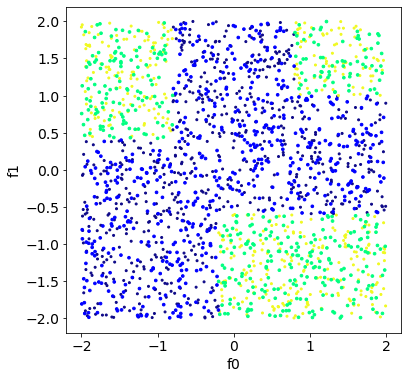

In [6]:
np.random.seed(123)
CASE = 1
S = 2
N = 2000
N_train = 1000
N_val  = N - N_train
x = S*(2*np.random.rand(N,2)-1)
y = np.zeros(N).astype(int)
for n in range(N):
    if CASE==1:
        if x[n,1]<-0.6 and x[n,0]>-0.2: y[n]=1
        if x[n,1]>0.4 and x[n,0]<-0.8: y[n]=1
        if x[n,1]>1.0 and x[n,0]>0.8: y[n]=1
    elif CASE==2:
        if x[n,1]<0 and x[n,0]>0.5: y[n]=1
        if x[n,1]>0 and np.sqrt((x[n,0]+0.3)**2+x[n,1]**2)<1.5: y[n]=1
x_train,y_train = x[:N_train],y[:N_train]
x_val,y_val = x[N_train:],y[N_train:]

for n in range(5):
    print(x[n],y[n])
plt.figure(figsize=(6,6))
scat(x_train,y_train)
scat(x_val,y_val,cmap="winter",s=7)
plt.show()

Data extraction

## Parameter Tuning

Main idea: choosen the parameters to tune, we find at each step the best parameter's value, and use it for the next tuning (GridSearch needs too much computational time)

In [7]:
from sklearn.metrics import accuracy_score
params_in_use = {'gamma':0.1,'lambda':0.1,'n_estimators':100,'max_depth':6}
best_params = dict()
def search(par_name, par_list,params_in_use):
    best_parameter, best_accuracy = 0, 0
    for parameter in par_list:
        params_standard = {'min_child_weight':1,'learning_rate':0.3,'use_label_encoder':False}
        params_in_use[par_name] = parameter
        model = XGBClassifier(**params_standard, **params_in_use)
        fit = model.fit(x_train,y_train, eval_metric='logloss', verbose=True)
        y_pred_val = model.predict(x_val)
        acc = accuracy_score(y_val,y_pred_val)
        if acc>best_accuracy:
            best_parameter = parameter
            best_accuracy = acc
        print(parameter, acc)
        best_params[par_name] = best_parameter
    print("best performance:", best_accuracy, "relative to", par_name,":", best_parameter)
    params_in_use[par_name] = best_parameter
    return params_in_use

In [8]:
#parameters
gamma_list = [0, 0.1, 0.001, 0.0001]
lmb_list = [0, 1e-1, 1e-3, 1e-5]
nest_list = [50,100,200]
depths_list = [3,6,10]
obj_list = ['reg:squarederror', 'reg:logistic', 'reg:squaredlogerror']

par_names = ['n_estimators','max_depth','objective','gamma','lambda']
par_lists = [nest_list,depths_list,obj_list,gamma_list,lmb_list]
l = len(par_names)

#simple search
par_name_found, par_value_found = ['0']*l, [0]*l
for (i,par_name,par_list) in zip(range(l),par_names,par_lists):
    print("----", par_name, "----")
    params_in_use = search(par_name, par_list, params_in_use)

---- n_estimators ----
50 0.998
100 0.998
200 0.998
best performance: 0.998 relative to n_estimators : 50
---- max_depth ----
3 0.995
6 0.998
10 0.998
best performance: 0.998 relative to max_depth : 6
---- objective ----
reg:squarederror 0.998
reg:logistic 0.998
reg:squaredlogerror 0.998
best performance: 0.998 relative to objective : reg:squarederror
---- gamma ----
0 0.998
0.1 0.998
0.001 0.998
0.0001 0.998
best performance: 0.998 relative to gamma : 0
---- lambda ----
0 0.998
0.1 0.998
0.001 0.998
1e-05 0.998
best performance: 0.998 relative to lambda : 0


---Summit---
 {'n_estimators': 50, 'max_depth': 6, 'objective': 'reg:squarederror', 'gamma': 0, 'lambda': 0}
errors: 0.20%


C:\Users\Marco\Documents\Anaconda\envs\tensorflow\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


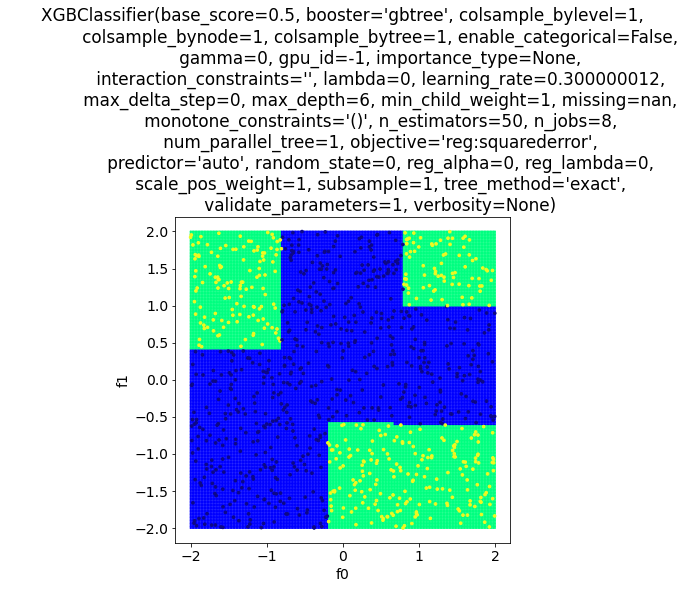

num_trees= 50


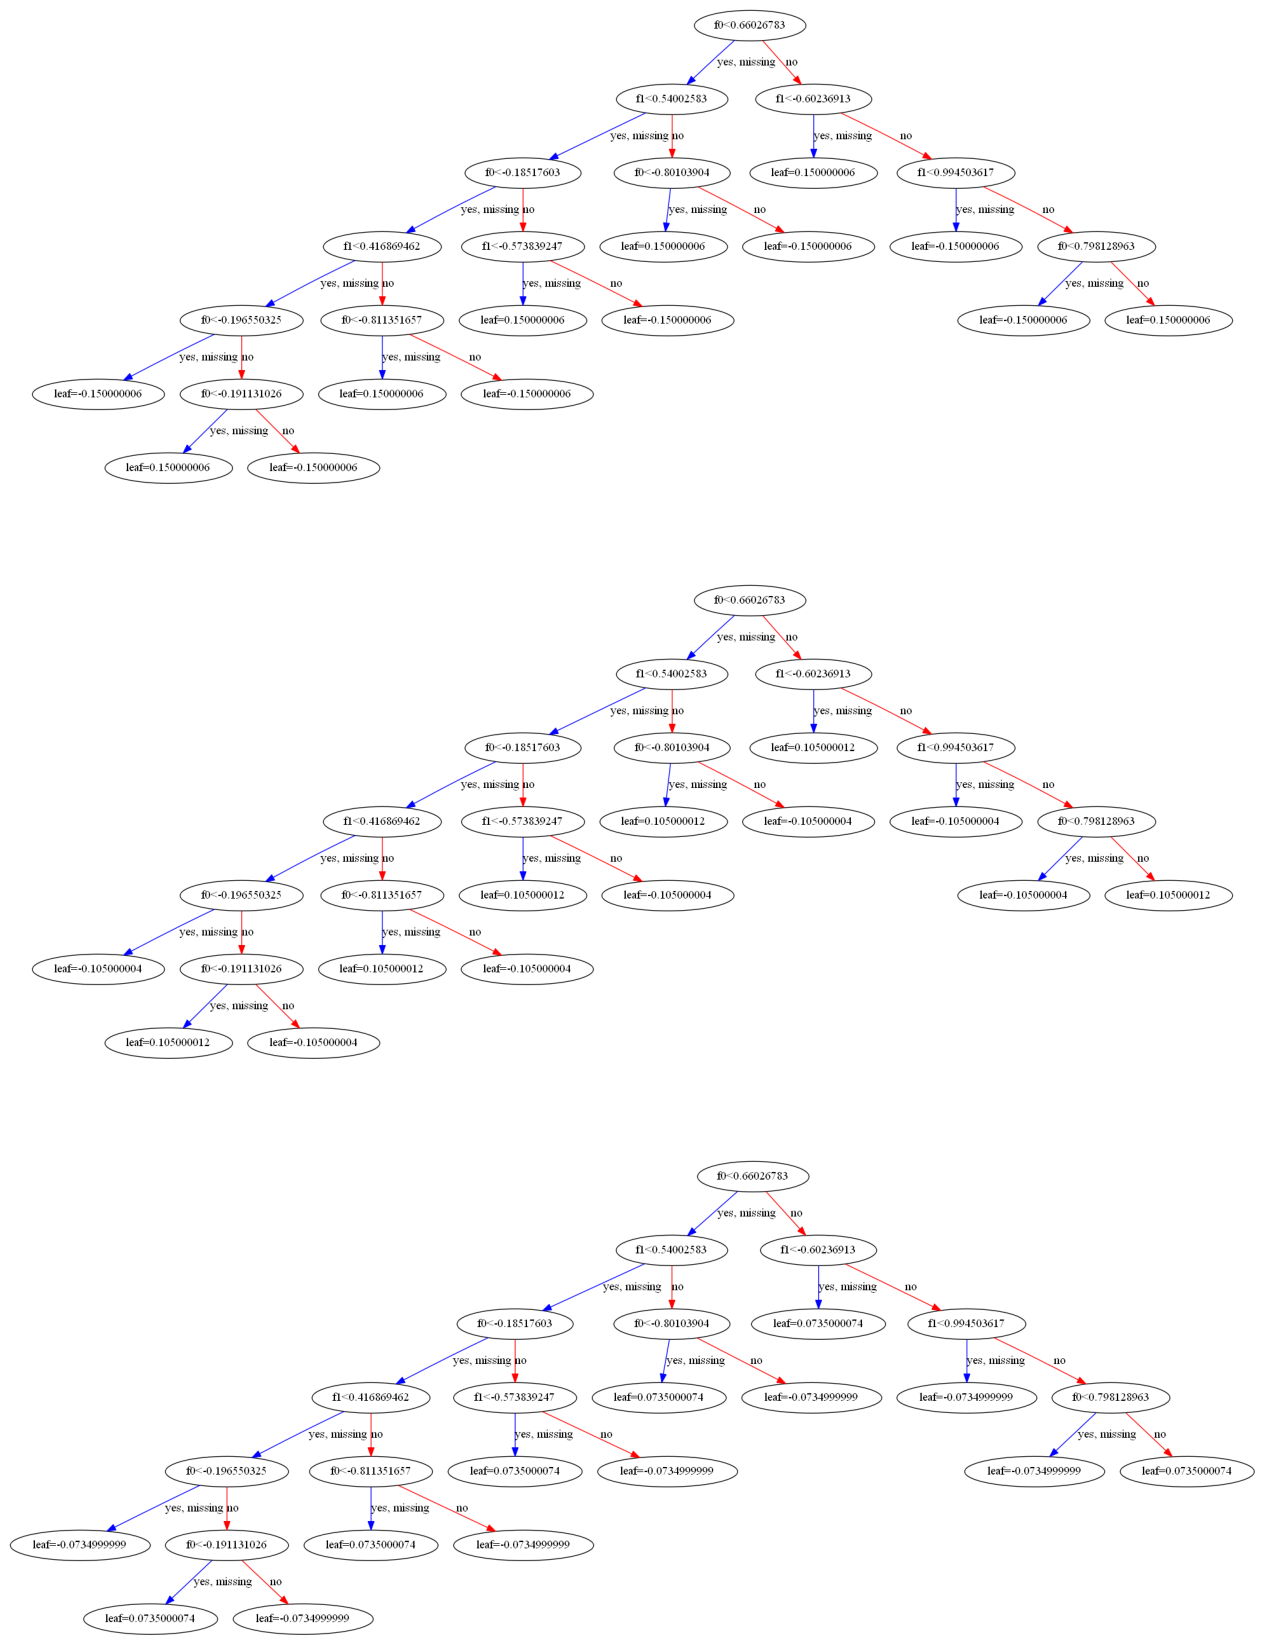

In [11]:
# best_params.pop('0')
print("---Summit---\n", best_params)
classify(XGBClassifier(**best_params),show=True)

C:\Users\Marco\Documents\Anaconda\envs\tensorflow\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training accuracy: 1.0
Validation accuracy: 0.998


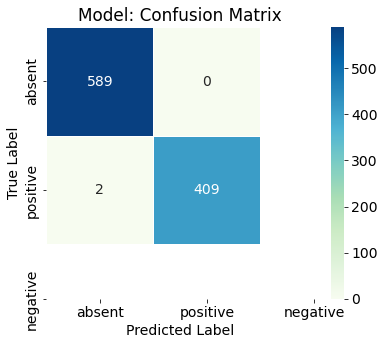

In [13]:
import seaborn as sns
LABELS = ["absent","positive","negative"]
cmap="GnBu"

best_model = XGBClassifier(**best_params)
best_fit = best_model.fit(x_train,y_train)
#compute accuracies
y_pred_val = best_model.predict(x_val)
y_pred_train = best_model.predict(x_train)
acc_train = accuracy_score(y_train,y_pred_train) 
acc_val = accuracy_score(y_val,y_pred_val)
print('Training accuracy:',acc_train)
print('Validation accuracy:',acc_val)
#Confusion Matrix
show_confusion_matrix(y_val, y_pred_val)